# <a id='toc1_'></a>[Preprocessing using XGBoost](#toc0_)

In this notebook I'll try some basic modeling with XGBoost to get a feel for how the data with the features I've created are working.
The work here will inform possible additional feature engineering steps and modeling steps. 

**Table of contents**<a id='toc0_'></a>    
- [Preprocessing using XGBoost](#toc1_)    
- [Module and Data Imports](#toc2_)    
- [Define function to check class ratios](#toc3_)    
- [Subset the data while building](#toc4_)    
- [Drop unneeded columns to prepare data for modeling](#toc5_)    
- [Dummy Encoder for Sex Feature](#toc6_)    
- [Train Test Split - Leipzig with engineered features](#toc7_)    
- [Train Test Split - Leipzig with engineered features 0-6 hour window](#toc8_)    
- [XGBoost Model - All Leipzig data with engineered features](#toc9_)    
  - [Define scoring function](#toc9_1_)    
  - [Run XGBoost model](#toc9_2_)    
  - [ XGBoost - Different estimator values](#toc9_3_)    
  - [Explore Precision Recall curve thresholds](#toc9_4_)    
    - [Find optimal F1 score](#toc9_4_1_)    
      - [Confusion matrix at optimal threshold](#toc9_4_1_1_)    
    - [Confusion Matrix at max Precision](#toc9_4_2_)    
    - [Confusion Matrix at 0.1 Threshold](#toc9_4_3_)    
    - [Confusion Matrix at 0.8 Threshold](#toc9_4_4_)    
    - [Threshold Scores Comparison](#toc9_4_5_)    
- [XGBoost Model - All Leipzig data with engineered features 0-6 hour window](#toc10_)    
  - [Threshold Scores - Full data vs. sliding time window](#toc10_1_)    
- [Random undersampling and Majority Vote with XGBoost](#toc11_)    
  - [Define Majority Vote function](#toc11_1_)    
    - [Create voting matrix for 0.5 Threshold](#toc11_1_1_)    
    - [Create voting matrix for 0.1 Threshold](#toc11_1_2_)    
    - [Create voting matrix for 0.9 Threshold](#toc11_1_3_)    
  - [Threshold Plots for majority voting](#toc11_2_)    
    - [Accuracy](#toc11_2_1_)    
    - [Precision and Recall](#toc11_2_2_)    
    - [F1, F05, F2 Scores](#toc11_2_3_)    
    - [MCC Scores](#toc11_2_4_)    
- [Time windows applied to positive class only](#toc12_)    
  - [Import data](#toc12_1_)    
    - [Drop uneeded columns](#toc12_1_1_)    
    - [Encode Sex Feature](#toc12_1_2_)    
  - [Train Test Split](#toc12_2_)    
  - [XGBoost Model](#toc12_3_)    
  - [Try various Thresholds](#toc12_4_)    
  - [Undersampling with XGBoost](#toc12_5_)    
  - [Undersampling and Majority Vote with XGBoost](#toc12_6_)    
- [Undersampling and Majority Vote Across multiple time windows.](#toc13_)    
- [HrsToICU time Window - Majority vote vs. Single model - Features vs. No Features Comparison](#toc14_)    
  - [Run models with engineered features removed](#toc14_1_)    
  - [Visualize Features vs. No Features and Single vs. Majority Vote together](#toc14_2_)    
- [Summary](#toc15_)    
  - [Approach 1 - Single XGBoost model](#toc15_1_)    
  - [Approach 2 - Sliding time window for positive and negative clasess](#toc15_2_)    
  - [Approach 3 - Majority Vote with XGBoost](#toc15_3_)    
  - [Approach 4 - Subsetting Positive Class on time from ICU admission](#toc15_4_)    
  - [Final comparisons and next steps](#toc15_5_)    
    - [Full data Track](#toc15_5_1_)    
    - [Time from ICU track](#toc15_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Module and Data Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, matthews_corrcoef
from imblearn.under_sampling import RandomUnderSampler


In [2]:
leipzig_full_data_with_engineered_features = pd.read_csv('../data/processed/data_with_engineered_features/leipzig_full_data_with_engineered_features.csv', index_col = 0)
leipzig_full_data_with_engineered_features_0_to_6_window = pd.read_csv('../data/processed/data_with_engineered_features/leipzig_full_data_with_engineered_features_0_to_6_window.csv', index_col = 0)

In [3]:
leipzig_full_data_with_engineered_features.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,...,RBC_cumulative_mean,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,...,4.36,4.36,0.0,4.36,4.36,7.3,7.3,0.0,7.3,7.3
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,...,6.02,6.02,0.0,6.02,6.02,4.7,4.7,0.0,4.7,4.7
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,...,4.37,4.37,0.0,4.37,4.37,7.1,7.1,0.0,7.1,7.1
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,...,4.79,4.79,0.0,4.79,4.79,5.3,5.3,0.0,5.3,5.3
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,...,3.96,3.96,0.0,3.96,3.96,20.9,20.9,0.0,20.9,20.9


# <a id='toc3_'></a>[Define function to check class ratios](#toc0_)
Class imbalance is a major part of this project. I'll define a function below that will let me check the ratio of 
classes before and after the train test split.

In [4]:
def check_binary_labels_ratio(df, label = None):
    '''
    This function takes a data frame and class column and returns the 
    ratio of the classes in the dataframe. 

    Parameters:
    df = This is a pandas dataframe
    label = A string cooresponding to the column containing the class labels.
    if label is not defined, the function assumes that the df variable is a series
    '''

    if label != None:
        class_counts = df[label].value_counts()

        # Total number of entries
        total = len(df)

        # Calculate percentage for each class
        class_percentages = (class_counts / total) * 100

        # Calculate the ratio
        class_ratio = class_counts.iloc[0] / class_counts.iloc[1] if class_counts.iloc[1] != 0 else float('inf')
    
    else:

        class_counts = df.value_counts()

        # Total number of entries
        total = len(df)

        # Calculate percentage for each class
        class_percentages = (class_counts / total) * 100

        # Calculate the ratio
        class_ratio = class_counts.iloc[0] / class_counts.iloc[1] if class_counts.iloc[1] != 0 else float('inf')


    # Print the counts and ratio
    print("Class counts:\n", class_counts)
    print("Ratio of classes (class 1 to class 2):", class_ratio)

    # Print the percentages
    print("\nClass percentages:\n", class_percentages)

# <a id='toc4_'></a>[Subset the data while building](#toc0_)
I'm selecting just a small subset of the data here to use while building the notebook. 
This will help avoid long processing times during building. 

In [5]:
#print(len(leipzig_full_data_with_engineered_features))

In [6]:
#leipzig_full_data_with_engineered_features = leipzig_full_data_with_engineered_features.sample(frac=0.10, random_state=1)
#print(len(leipzig_full_data_with_engineered_features))

# <a id='toc5_'></a>[Drop unneeded columns to prepare data for modeling](#toc0_)

In [7]:
#leipzig_full_data_with_engineered_features.columns

In [8]:
cols_to_drop = ['Id','Diagnosis','Center','SecToIcu','CRP','PCT','HrsToIcu']
leipzig_full_data_with_engineered_features.drop(columns=cols_to_drop, inplace=True)
leipzig_full_data_with_engineered_features_0_to_6_window.drop(columns=cols_to_drop, inplace=True)

In [9]:
#leipzig_full_data_with_engineered_features.columns

# <a id='toc6_'></a>[Dummy Encoder for Sex Feature](#toc0_)

In [10]:
leipzig_full_data_with_engineered_features = pd.get_dummies(leipzig_full_data_with_engineered_features, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)
leipzig_full_data_with_engineered_features_0_to_6_window = pd.get_dummies(leipzig_full_data_with_engineered_features_0_to_6_window, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)

In [11]:
#leipzig_full_data_with_engineered_features.head()

# <a id='toc7_'></a>[Train Test Split - Leipzig with engineered features](#toc0_)

This is the train test split for the Leipzig data with all of the engineered features from the Feature Engineering Notebook

In [12]:
X_leipzig_with_new_features = leipzig_full_data_with_engineered_features.drop(columns = ['Class'])
y_leipzig_with_new_features = leipzig_full_data_with_engineered_features['Class']

X_train, X_test, y_train, y_test = train_test_split(X_leipzig_with_new_features, y_leipzig_with_new_features, test_size=0.2, random_state=42, stratify=y_leipzig_with_new_features)

In [13]:
print('Whole dataframe:')
check_binary_labels_ratio(leipzig_full_data_with_engineered_features,'Class')
print('\n')

print('Training set:')
check_binary_labels_ratio(y_train)
print('\n')

print('Test Set:')
check_binary_labels_ratio(y_test)

Whole dataframe:
Class counts:
 Class
0    1364704
1      16654
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 81.9445178335535

Class percentages:
 Class
0    98.794375
1     1.205625
Name: count, dtype: float64


Training set:
Class counts:
 Class
0    1091763
1      13323
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 81.94573294303085

Class percentages:
 Class
0    98.794392
1     1.205608
Name: count, dtype: float64


Test Set:
Class counts:
 Class
0    272941
1      3331
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 81.9396577604323

Class percentages:
 Class
0    98.794304
1     1.205696
Name: count, dtype: float64


Looks like the class ratios are being maintained after the split. 

# <a id='toc8_'></a>[Train Test Split - Leipzig with engineered features 0-6 hour window](#toc0_)

This is the train test split for the Leipzig data with all of the engineered features
AND with the data subset on a 0-6 hour sliding window as defined in the Feature Engineering Notebook.

In [14]:
X_leipzig_with_new_features_0_6_window = leipzig_full_data_with_engineered_features_0_to_6_window.drop(columns = ['Class'])
y_leipzig_with_new_features_0_6_window = leipzig_full_data_with_engineered_features_0_to_6_window['Class']

X_train_0_6, X_test_0_6, y_train_0_6, y_test_0_6 = train_test_split(X_leipzig_with_new_features_0_6_window, y_leipzig_with_new_features_0_6_window, test_size=0.2, random_state=42, stratify=y_leipzig_with_new_features_0_6_window)

In [15]:
print('Whole dataframe:')
check_binary_labels_ratio(leipzig_full_data_with_engineered_features_0_to_6_window,'Class')
print('\n')

print('Training set:')
check_binary_labels_ratio(y_train_0_6)
print('\n')

print('Test Set:')
check_binary_labels_ratio(y_test_0_6)

Whole dataframe:
Class counts:
 Class
0    709272
1      3003
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 236.1878121878122

Class percentages:
 Class
0    99.578393
1     0.421607
Name: count, dtype: float64


Training set:
Class counts:
 Class
0    567418
1      2402
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 236.22731057452123

Class percentages:
 Class
0    99.578463
1     0.421537
Name: count, dtype: float64


Test Set:
Class counts:
 Class
0    141854
1       601
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 236.02995008319468

Class percentages:
 Class
0    99.578112
1     0.421888
Name: count, dtype: float64


Class ratios are preserved again. They are considerably worse becasue of the way the time window has been defined. 

# <a id='toc9_'></a>[XGBoost Model - All Leipzig data with engineered features](#toc0_)

This will basically be an out of the box XGBoost Model. It's a way to establish a baseline for further work. It's being run on the data for Leipzig only, since that is the largest 
medical center. 

## <a id='toc9_1_'></a>[Define scoring function](#toc0_)

In [16]:
#Define a function to evaluate how different classification schemes are doing

class Classifier_scores_object:
    def __init__(self, accuracy, precision, recall,f1,f05,f2,mcc):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1
        self.f05= f05
        self.f2 = f2
        self.mcc = mcc

In [17]:
def create_classifier_scores_object(y_test, y_pred, print_results = False):
        '''
        This function takes the predictons from a model and computes various classification metrics. 
        It assigns those metrics to an object that can be used to produce different scores as attributes 
        as needed. 

        y_test: Test data from a train test split
        y_pred: Prediction data from a classification model. 
        print_results: Optional argument - causes the function to print all the scores to the screen if True. 

        Returns: Object containing the computed scores. 
        '''

        accuracy = accuracy_score(y_test, y_pred)  
        precision = precision_score(y_test, y_pred)  
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f05 = fbeta_score(y_test, y_pred, beta = 0.5) 
        f2 = fbeta_score(y_test, y_pred, beta = 2)
        mcc = matthews_corrcoef(y_test, y_pred) 

        # Create an object with the computed attributes
        obj = Classifier_scores_object(accuracy, precision, recall,f1,f05,f2,mcc)

        if print_results == True:
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1: {f1}')
            print(f'F05: {f05}')
            print(f'F2: {f2}')
            print(f'Matthews Corr Coef: {mcc}')
    

        return obj

## <a id='toc9_2_'></a>[Run XGBoost model](#toc0_)

This is a first pass at modeling with XGBoost. I've chosen a large number of estimators to start becasue of the apparent complexity of the data and 
the class imbalance. 

In [18]:
# Create an XGBoost model
model = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

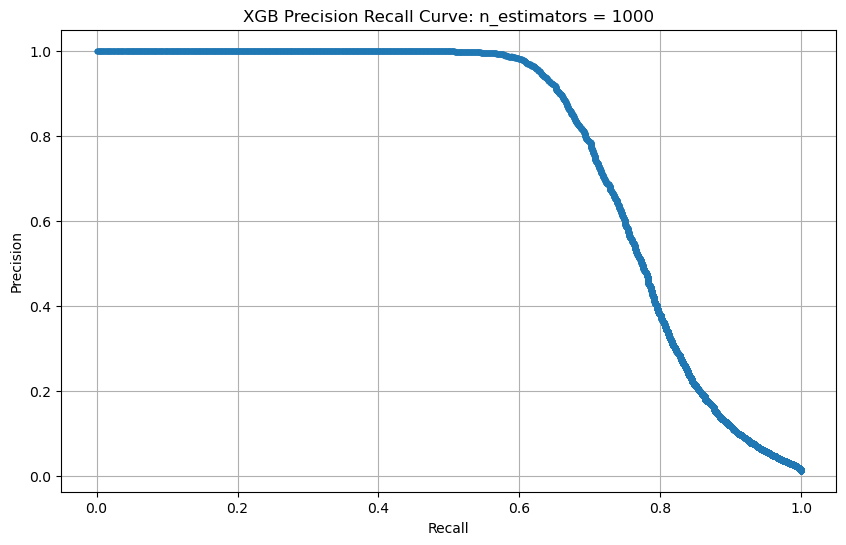

In [19]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Precision Recall Curve: n_estimators = 1000')
plt.grid()
plt.show()

This is a decent Precison and Recall curve. It's running on the imbalanced data but still acheiving some performance. The 
only issue is that this is the full data set, so some of the cases labeled as Sepsis here are from blood tests that are actually months away from 
actually getting sepsis. 

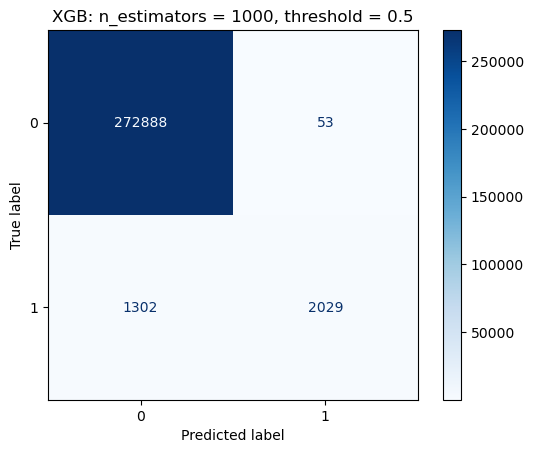

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGB: n_estimators = 1000, threshold = 0.5')
plt.show()

In [21]:
threshold_05_scores = create_classifier_scores_object(y_test, y_pred, print_results=True)

Accuracy: 0.9950954132159611
Precision: 0.9745437079731027
Recall: 0.6091263884719303
F1: 0.7496767042305561
F05: 0.8701432369843041
F2: 0.6585096715565365
Matthews Corr Coef: 0.7684656902695668


The large class imbalance is evident here. The accuracy is high but the classification for the positive class isn't very good. 
There are a lot of false negatives. The model is seeing something, but it could use improvement. 

## <a id='toc9_3_'></a>[ XGBoost - Different estimator values](#toc0_)

In [22]:
estimators = [100,250,500,1000,2000,5000]
accuracy_scores = []
f1_scores = []

for estimator in estimators:
    # Create an XGBoost model
    model = xgb.XGBClassifier(
    n_estimators = estimator,           # Defaul number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

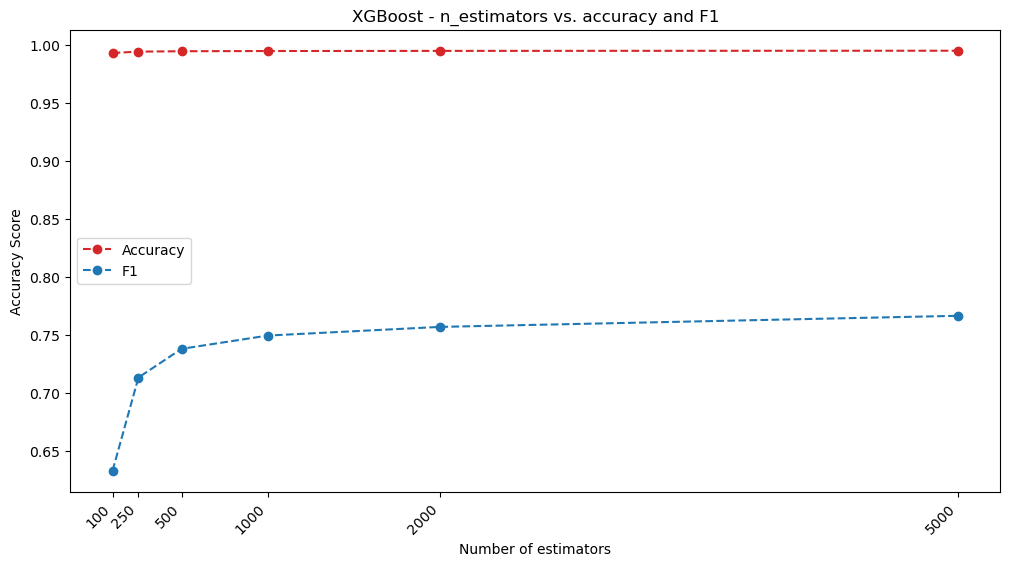

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(estimators,accuracy_scores, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Accuracy')
plt.plot(estimators,f1_scores, marker = 'o',color = 'tab:blue' ,linestyle = '--',  label = 'F1')

plt.xticks(estimators,rotation=45, ha='right' )
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy Score')

plt.title('XGBoost - n_estimators vs. accuracy and F1')
plt.legend(loc = 'center left')

plt.show()

Increasing the number of estimators increases the accuracy very slightly. But that high accuracy seems to be coming from the large class imbalance.
Even if the model classified everything as the negative class, the accuracy would be very high. 

The F1 score does show a significant increase up to 1000 estimators, but then levels off. For the purposes of this notebook. I'll stick with 1000 estimators
moving forward. It should help establish a baseline and can be tweaked during hyperparameter tuning. 

## <a id='toc9_4_'></a>[Explore Precision Recall curve thresholds](#toc0_)

### <a id='toc9_4_1_'></a>[Find optimal F1 score](#toc0_)

In [24]:
#using F1 score

precision, recall, thresholds = precision_recall_curve(y_test,
y_pred_prob)

f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(optimal_threshold)

0.27774847


#### <a id='toc9_4_1_1_'></a>[Confusion matrix at optimal threshold](#toc0_)

In [25]:
# Predict probabilities for the positive class (class 1)

# Define a new threshold
threshold = optimal_threshold  # Example threshold

# Classify instances based on the new threshold
y_pred_custom_optimal = (y_pred_prob >= threshold).astype(int)

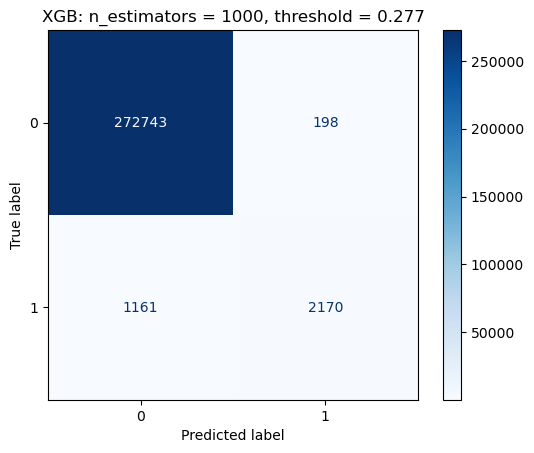

In [26]:
cm = confusion_matrix(y_test, y_pred_custom_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGB: n_estimators = 1000, threshold = 0.277')
plt.show()

In [27]:
threshold_optimal_threashold_scores = create_classifier_scores_object(y_test, y_pred_custom_optimal, print_results=True)

Accuracy: 0.9950809347309898
Precision: 0.9163851351351351
Recall: 0.6514560192134494
F1: 0.7615371117739954
F05: 0.847457627118644
F2: 0.6914351261789446
Matthews Corr Coef: 0.7704294765986298


### <a id='toc9_4_2_'></a>[Confusion Matrix at max Precision](#toc0_)

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test,
y_pred_prob)


max_precision_threshold = thresholds[np.argmax(precision)]
print(max_precision_threshold)

# Define a new threshold
threshold = max_precision_threshold  # Example threshold

# Classify instances based on the new threshold
y_pred_custom_max_precision = (y_pred_prob >= threshold).astype(int)

0.9926502


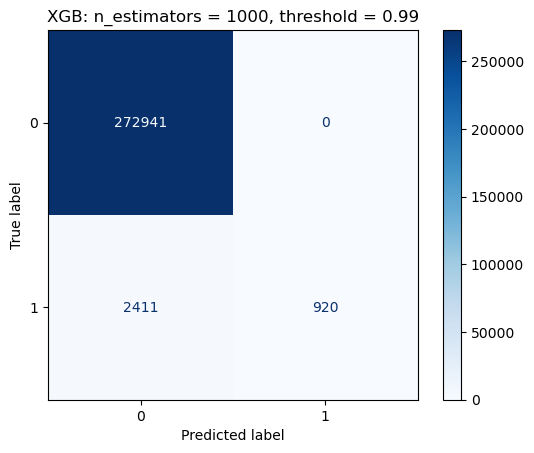

In [29]:
cm = confusion_matrix(y_test, y_pred_custom_max_precision)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGB: n_estimators = 1000, threshold = 0.99')
plt.show()

In [30]:
threshold_max_precison_threashold_scores = create_classifier_scores_object(y_test, y_pred_custom_max_precision, print_results=True)

Accuracy: 0.9912730931835293
Precision: 1.0
Recall: 0.27619333533473434
F1: 0.43283933192190077
F05: 0.6561118242761376
F2: 0.32294299354114014
Matthews Corr Coef: 0.5232350987346766


### <a id='toc9_4_3_'></a>[Confusion Matrix at 0.1 Threshold](#toc0_)

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test,
y_pred_prob)


low_threshold = 0.1

# Predict probabilities for the positive class (class 1)

# Define a new threshold
threshold = low_threshold  # Example threshold

# Classify instances based on the new threshold
y_pred_custom_low_thres = (y_pred_prob >= threshold).astype(int)

In [32]:
print(accuracy_score(y_test, y_pred_custom_low_thres))

0.9933507557769155


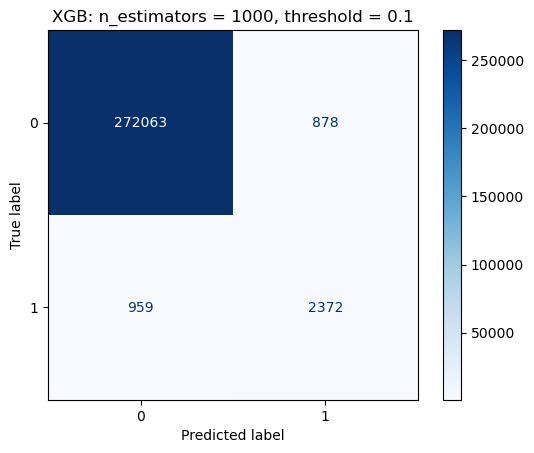

In [33]:
cm = confusion_matrix(y_test, y_pred_custom_low_thres)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGB: n_estimators = 1000, threshold = 0.1')
plt.show()

In [34]:
threshold_low_threashold_scores = create_classifier_scores_object(y_test, y_pred_custom_low_thres, print_results=True)

Accuracy: 0.9933507557769155
Precision: 0.7298461538461538
Recall: 0.7120984689282498
F1: 0.7208630907156968
F05: 0.7262261955789603
F2: 0.715578617111138
Matthews Corr Coef: 0.717554581313714


### <a id='toc9_4_4_'></a>[Confusion Matrix at 0.8 Threshold](#toc0_)

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test,
y_pred_prob)


high_threshold = 0.8

# Predict probabilities for the positive class (class 1)

# Define a new threshold
threshold = high_threshold  # Example threshold

# Classify instances based on the new threshold
y_pred_custom_high_thresh = (y_pred_prob >= threshold).astype(int)

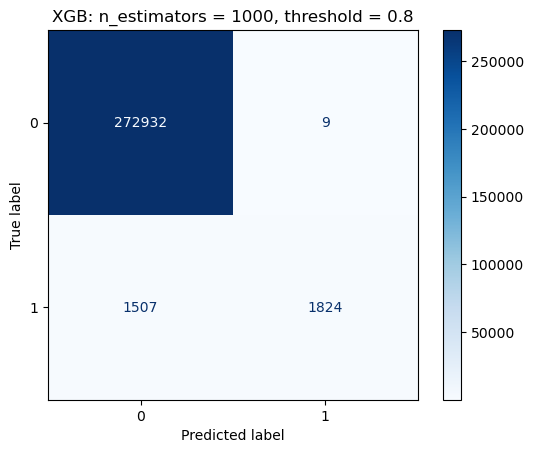

In [36]:
cm = confusion_matrix(y_test, y_pred_custom_high_thresh )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGB: n_estimators = 1000, threshold = 0.8')
plt.show()

In [37]:
threshold_high_threashold_scores = create_classifier_scores_object(y_test, y_pred_custom_high_thresh, print_results=True)

Accuracy: 0.994512654195865
Precision: 0.9950900163666121
Recall: 0.547583308315821
F1: 0.7064291247095275
F05: 0.8552940073150145
F2: 0.6017021838094609
Matthews Corr Coef: 0.7361081180497943


For all of the thresholds above, there is relatively little change. The model is very accurate, almost 100% accurate, but the accuracy seems to be coming from the very large class imbalance in the data. The model is correctly classifying the negative class, which means it's right almost all the time because the negative class is so large.

Even with the small changes in accruacy, some of the other metrics change quite a lot. I'll summarize them in the table below.

### <a id='toc9_4_5_'></a>[Threshold Scores Comparison](#toc0_)

In [38]:
classifer_scores_objects = [threshold_05_scores, threshold_optimal_threashold_scores, threshold_max_precison_threashold_scores, threshold_low_threashold_scores,
threshold_high_threashold_scores]

scores = {
    'Accuracy':[],
    'Precison': [],
    'Recall': [],
    'F1': [],
    'F0.5': [],
    'F2': [],
    'Matthews Coef.': []
}

for obj in classifer_scores_objects:
    scores['Accuracy'].append(round(obj.accuracy,3))
    scores['Precison'].append(round(obj.precision,3))
    scores['Recall'].append(round(obj.recall,3))
    scores['F1'].append(round(obj.f1,3))
    scores['F0.5'].append(round(obj.f05,3))
    scores['F2'].append(round(obj.f2,3))
    scores['Matthews Coef.'].append(round(obj.mcc,3))


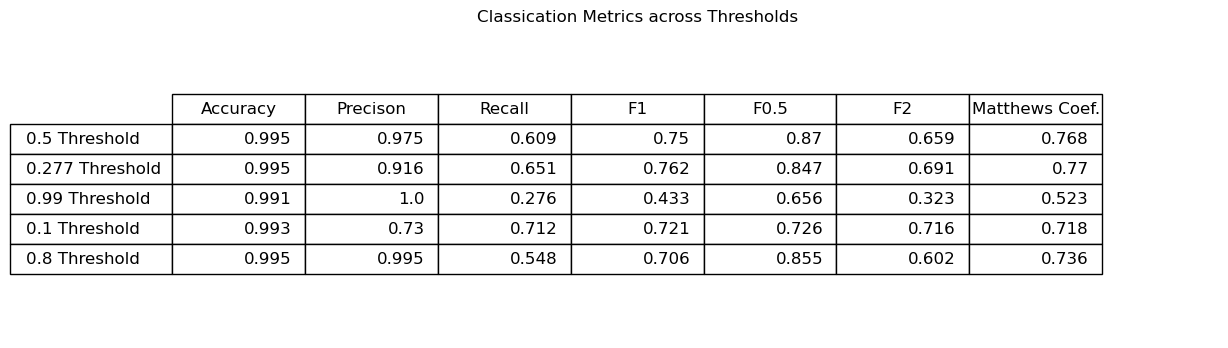

In [39]:
df = pd.DataFrame(scores, index=['0.5 Threshold', '0.277 Threshold', '0.99 Threshold', '0.1 Threshold','0.8 Threshold'])

# Plot a table
fig, ax = plt.subplots(figsize=(15, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

plt.title('Classication Metrics across Thresholds')
 
plt.show()

The model looks like a promising start for further development. Changing the threshold has a noticable effect on the metrics and would 
allow the final model to be tuned to have fewer false negatives, which would generally be the goal in a disease detecton scenario like this. 

# <a id='toc10_'></a>[XGBoost Model - All Leipzig data with engineered features 0-6 hour window](#toc0_)

This section will apply similar steps to the sections above, but this time only to the data that falls within a sliding time window of 0-6 hours. 
The sliding window applies to both the positive and negative class. See Feature Engineering notebook for more details. 

In [40]:
# Create an XGBoost model
model_0_6 = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)

# Train the model
model_0_6.fit(X_train_0_6, y_train_0_6)

# Make predictions
y_pred_0_6 = model_0_6.predict(X_test_0_6)
y_pred_prob_0_6 = model_0_6.predict_proba(X_test_0_6)[:, 1]  # Probability estimates for positive class

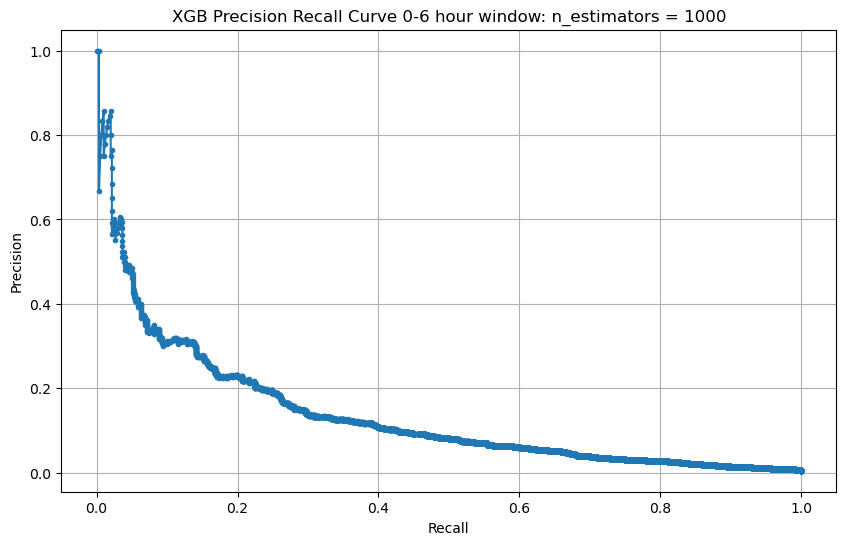

In [41]:
# Precision-Recall Curve 0-6 hour window
precision, recall, thresholds = precision_recall_curve(y_test_0_6, y_pred_prob_0_6)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Precision Recall Curve 0-6 hour window: n_estimators = 1000')
plt.grid()
plt.show()

Not a great precision recall curve.The performance seems to be generally worse for the 0-6 hour window.
The accuracy is still very high. 
The 0-6 hour window has a much more severe class imbalance than the whole data set with the same features.  The class imbalance is really one of the major
issues with this problem, and making it worse by limiting the time window in this way doesn't seem to be helping. 

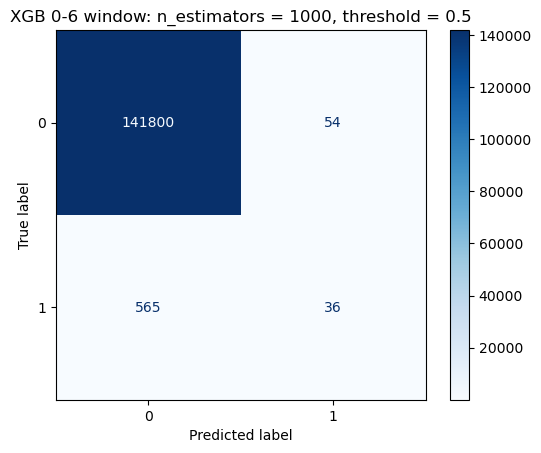

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test_0_6, y_pred_0_6)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_0_6.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGB 0-6 window: n_estimators = 1000, threshold = 0.5')
plt.show()

These are not encouraging results. Especially since the 0-6 hour window is not comparable to any other windows because of the large disparity in the amount
of data falling into the various windows. It looks like a different approach is needed. I'll visualize the 0-6 hour time window results along with the results from the full data set below for comparison. 

## <a id='toc10_1_'></a>[Threshold Scores - Full data vs. sliding time window](#toc0_)

In [43]:
threshold_0_6_hour_scores = create_classifier_scores_object(y_test_0_6, y_pred_0_6, print_results=True)

Accuracy: 0.9956547681724053
Precision: 0.4
Recall: 0.059900166389351084
F1: 0.10419681620839363
F05: 0.18730489073881373
F2: 0.07217321571772253
Matthews Corr Coef: 0.15353040080117025


In [44]:
classifer_scores_objects = [threshold_05_scores, threshold_optimal_threashold_scores, threshold_max_precison_threashold_scores, threshold_low_threashold_scores,
threshold_high_threashold_scores,threshold_0_6_hour_scores]

scores_time_window = {
    'Accuracy':[],
    'Precison': [],
    'Recall': [],
    'F1': [],
    'F0.5': [],
    'F2': [],
    'Matthews Coef.': []
}

for obj in classifer_scores_objects:
    scores_time_window['Accuracy'].append(round(obj.accuracy,3))
    scores_time_window['Precison'].append(round(obj.precision,3))
    scores_time_window['Recall'].append(round(obj.recall,3))
    scores_time_window['F1'].append(round(obj.f1,3))
    scores_time_window['F0.5'].append(round(obj.f05,3))
    scores_time_window['F2'].append(round(obj.f2,3))
    scores_time_window['Matthews Coef.'].append(round(obj.mcc,3))

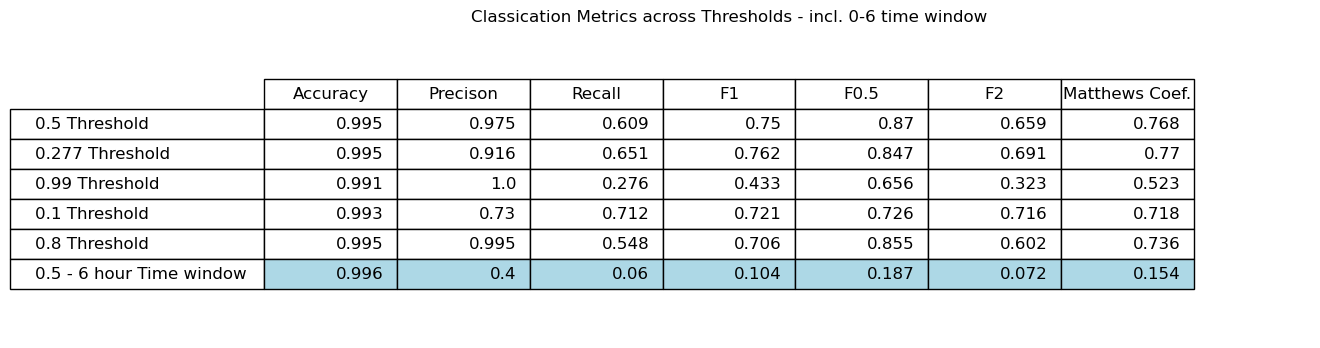

In [45]:
df = pd.DataFrame(scores_time_window, index=['0.5 Threshold', '0.277 Threshold', '0.99 Threshold', '0.1 Threshold','0.8 Threshold','0.5 - 6 hour Time window'])

# Plot a table
fig, ax = plt.subplots(figsize=(15, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

for i in range(len(df.columns)):
    table[(6, i)].set_facecolor('lightblue')


plt.title('Classication Metrics across Thresholds - incl. 0-6 time window')
 
plt.show()

The reuslts for the sliding time window are shown in blue above, juxtaposed with the prior results from the full data with various threshold values. 
Accuracy is still high, but the other metrics are very bad. I will won't be pursuing this approach any further.  

# <a id='toc11_'></a>[Random undersampling and Majority Vote with XGBoost](#toc0_)

This uses the same train test split of the Leipzig medical center with all the engineered features as the work above. 

The train test split is created here: [Train Test Split - Leipzig with engineered features](#toc7_) 

## <a id='toc11_1_'></a>[Define Majority Vote function](#toc0_)

In [47]:
def XGB_majority_vote(X_train, y_train, X_test, iter,threshold = 0.5, sampling_strategy = 'auto', return_matrix = True, return_y_pred_prob = False):
    '''
    This function takes a training set, undersamples the majority class and trains an XGB model
    on the resampled training set. The trained model generates predictions based on the X_test set 
    and adds those preditctions to the voting_matrix dataframe as a column. The is repeated (iter) times.
    When the dataframe is complete, a new column is added which is the mode/ majority vote of each row.

    X_train = A pandas dataframe for an x training set
    y_train = A pandas dataframe for a y training set
    X_test = A pandas dataframe for an x test set
    iter = an int, the number of iterations in the loop and number of columns in the final dataframe
    threshold = Optional float - sets the probability threshold 
    sampling strategy = Optional Int - sets the undersampling strategy
    return_matrix = Optional bool - if True, the function returns the majority vote of the predicitons
    return_y_pred_prob = Optional bool - if True, the function returns the mean vote of the probabilities as the last column

    Returns a dataframe with all prediciton runs as columns and a column with the majority vote for all runs. 

    '''

    #create the voting matrix as an empty dataframe
    voting_matrix = pd.DataFrame()

    #create dictionary for storing prediciton columns
    new_col_dict = {}
    new_col_dict_probs = {}

    for i in range(iter):
        column_name = f'sample_{i+1}'

    # Initialize the RandomUnderSampler
        under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)

    # Fit and transform the training data
        X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

    # Create an XGBoost model
        model_undersample = xgb.XGBClassifier(
        n_estimators = 1000,           # Large number of estimators
        objective='binary:logistic',  # For binary classification
        eval_metric='logloss',        # Evaluation metric
        use_label_encoder=False,       # Avoid deprecation warnings
        random_state=42
)

    # Train the model
        model_undersample.fit(X_resampled, y_resampled)

    # Make predictions
        if threshold == 0.5:
            y_pred = model_undersample.predict(X_test)
            new_col_dict[column_name] = y_pred

            y_pred_prob = model_undersample.predict_proba(X_test)[:, 1] 
            new_col_dict_probs[column_name] = y_pred_prob

        else:
            # Probability estimates for positive class
            y_pred_prob = model_undersample.predict_proba(X_test)[:, 1]  
            #precision, recall, thresholds = precision_recall_curve(y_test,y_pred_prob)
            
            # Classify instances based on the selected threshold
            y_pred_custom = (y_pred_prob >= threshold).astype(int)
            new_col_dict[column_name] = y_pred_custom


    if return_matrix == True:
        new_cols_df = pd.DataFrame(new_col_dict)
        voting_matrix = pd.concat([voting_matrix, new_cols_df], axis=1)

        modes = voting_matrix.mode(axis=1).iloc[:,0]
        voting_matrix['Majority_vote'] = modes
        voting_matrix['Majority_vote'] = voting_matrix['Majority_vote'].astype(int)

        return voting_matrix


    elif return_y_pred_prob == True:
        new_cols_df = pd.DataFrame(new_col_dict_probs)
        voting_matrix = pd.concat([voting_matrix, new_cols_df], axis=1)

        # Add the mean as a new column to the DataFrame
        voting_matrix['Majority_vote'] = voting_matrix.mean(axis=1)

        return voting_matrix

### <a id='toc11_1_1_'></a>[Create voting matrix for 0.5 Threshold](#toc0_)

In [48]:
#keep the default threshold and run multiple iteration options to see the effect on the classification metrics.
iterations = [100,250,500,1000,2000]

accuracy_scores = []
precision_scores= []
recall_scores = []
f1_scores = []
f05_scores = []
f2_scores = []
matthews_corrcoef_scores = []


for iteration in iterations:
    print(iteration)
    matrix = XGB_majority_vote(X_train, y_train, X_test, iter = iteration,threshold = 0.5, sampling_strategy = 'auto')
    scores = create_classifier_scores_object(y_test, matrix['Majority_vote'], print_results=False)

    accuracy_scores.append(scores.accuracy)
    precision_scores.append(scores.precision)
    recall_scores.append(scores.recall)
    f1_scores.append(scores.f1)
    f05_scores.append(scores.f05)
    f2_scores.append(scores.f2) 
    matthews_corrcoef_scores.append(scores.mcc)

100
250
500
1000
2000


### <a id='toc11_1_2_'></a>[Create voting matrix for 0.1 Threshold](#toc0_)

In [49]:
accuracy_scores_01 = []
precision_scores_01= []
recall_scores_01 = []
f1_scores_01 = []
f05_scores_01 = []
f2_scores_01 = []
matthews_corrcoef_scores_01 = []

for iteration in iterations:
    print(iteration)
    matrix = XGB_majority_vote(X_train, y_train, X_test, iter = iteration,threshold = 0.1, sampling_strategy = 'auto')
    scores = create_classifier_scores_object(y_test, matrix['Majority_vote'], print_results=False)

    accuracy_scores_01.append(scores.accuracy)
    precision_scores_01.append(scores.precision)
    recall_scores_01.append(scores.recall)
    f1_scores_01.append(scores.f1)
    f05_scores_01.append(scores.f05)
    f2_scores_01.append(scores.f2) 
    matthews_corrcoef_scores_01.append(scores.mcc)

100
250
500
1000
2000


### <a id='toc11_1_3_'></a>[Create voting matrix for 0.9 Threshold](#toc0_)

In [50]:
accuracy_scores_09 = []
precision_scores_09= []
recall_scores_09 = []
f1_scores_09 = []
f05_scores_09 = []
f2_scores_09 = []
matthews_corrcoef_scores_09 = []

for iteration in iterations:
    print(iteration)
    matrix = XGB_majority_vote(X_train, y_train, X_test, iter = iteration,threshold = 0.9, sampling_strategy = 'auto')
    scores = create_classifier_scores_object(y_test, matrix['Majority_vote'], print_results=False)

    accuracy_scores_09.append(scores.accuracy)
    precision_scores_09.append(scores.precision)
    recall_scores_09.append(scores.recall)
    f1_scores_09.append(scores.f1)
    f05_scores_09.append(scores.f05)
    f2_scores_09.append(scores.f2) 
    matthews_corrcoef_scores_09.append(scores.mcc)

100
250
500
1000
2000


## <a id='toc11_2_'></a>[Threshold Plots for majority voting](#toc0_)

### <a id='toc11_2_1_'></a>[Accuracy](#toc0_)

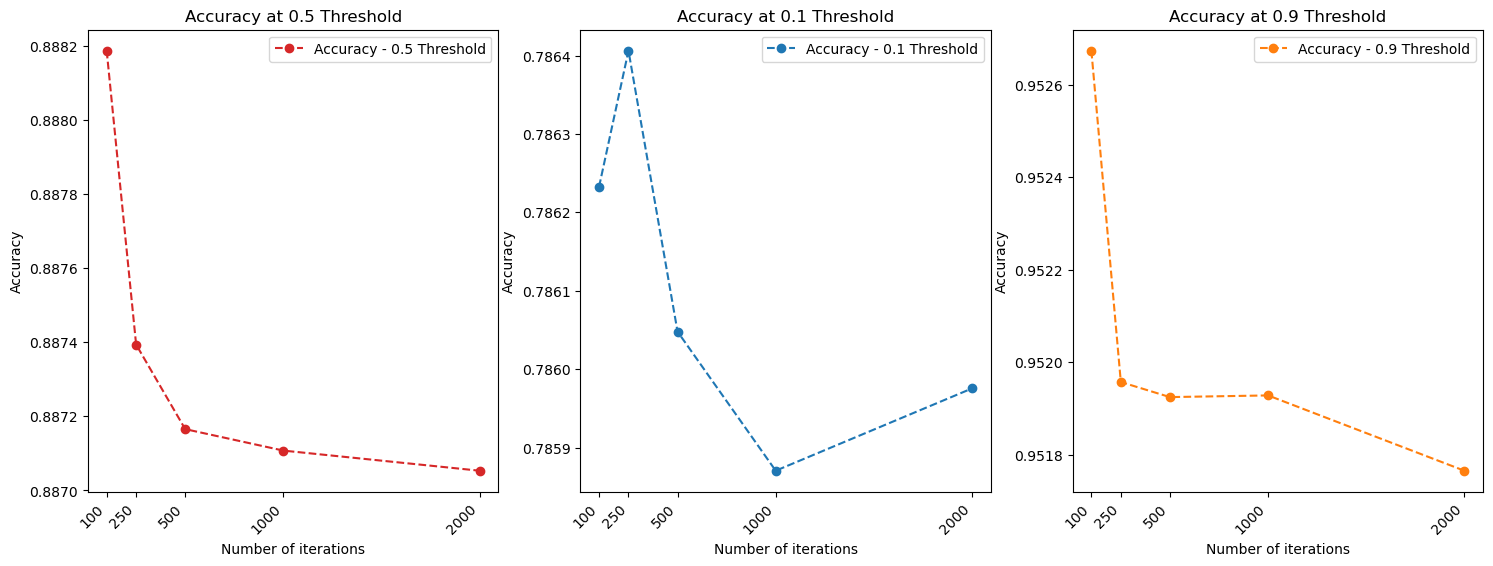

In [51]:
# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Accuracy scores at 0.5 threshold
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(iterations,accuracy_scores, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Accuracy - 0.5 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy at 0.5 Threshold')
plt.legend(loc='best')

# Plot for Accuracy scores at 0.1 threshold
plt.subplot(1, 3, 2)
plt.plot(iterations,accuracy_scores_01, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Accuracy - 0.1 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy at 0.1 Threshold')
plt.legend(loc='best');

# Plot for Accuracy scores at 0.1 threshold
plt.subplot(1, 3, 3)
plt.plot(iterations,accuracy_scores_09, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'Accuracy - 0.9 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy at 0.9 Threshold')
plt.legend(loc='best');

The accuracy here decreases as the number of iterations goes up. That's true across the three thresholds measured, although the 0.9 Threshold seems to perform best. 

### <a id='toc11_2_2_'></a>[Precision and Recall](#toc0_)

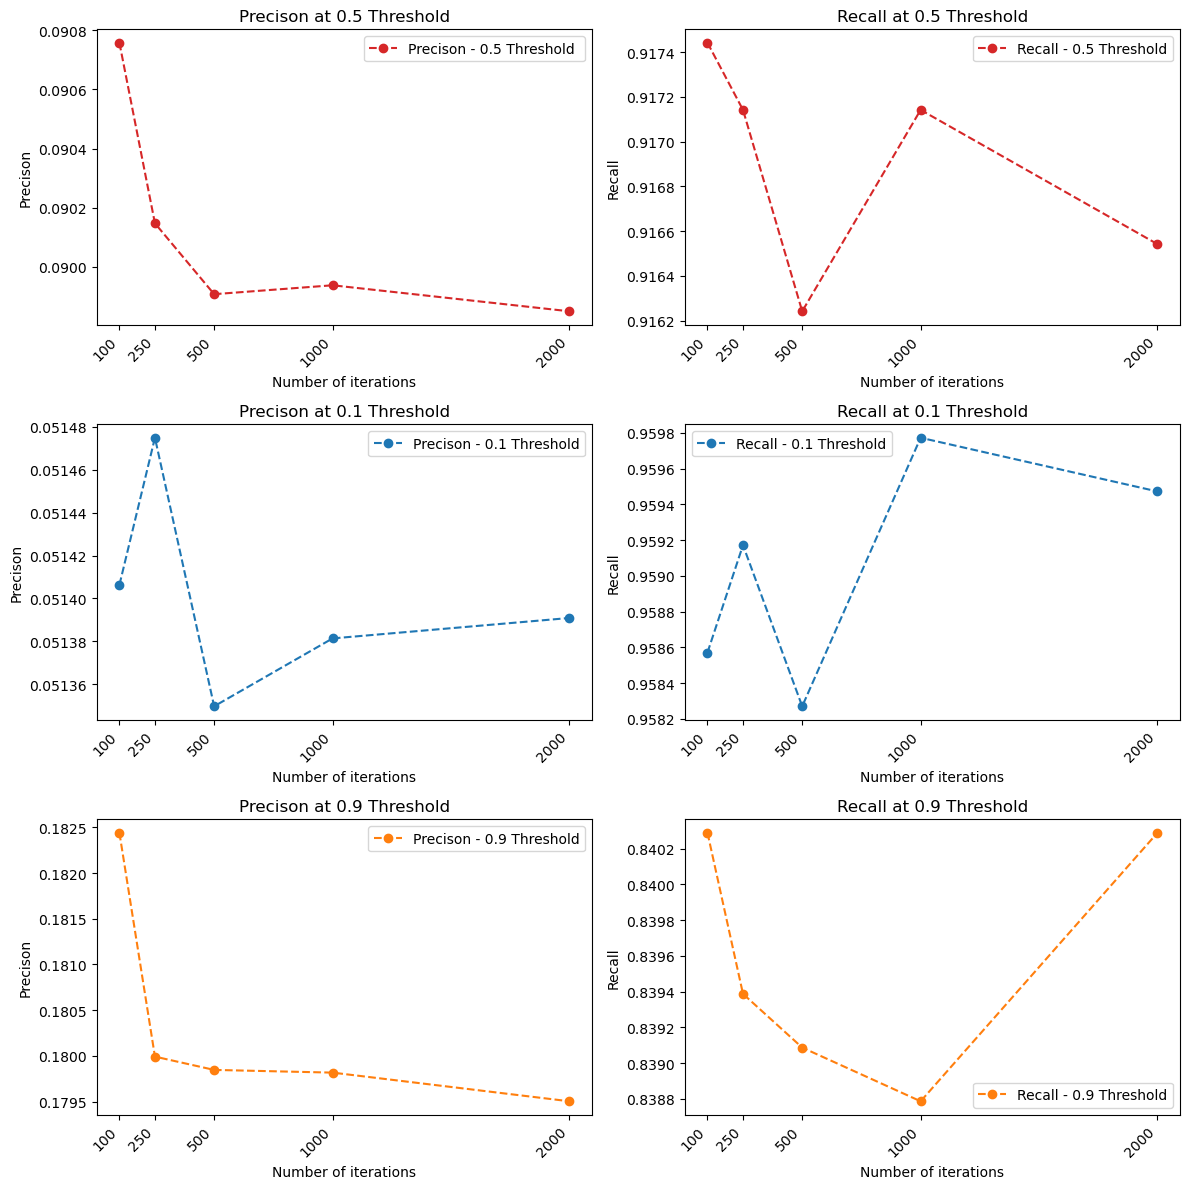

In [52]:

# Create a figure and set of subplots
plt.figure(figsize=(12, 12))


#Precison Scores

# Plot for Precision scores at 0.5 threshold
plt.subplot(3,2,1)  # (rows, cols, subplot_index)
plt.plot(iterations,precision_scores, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Precison - 0.5 Threshold ')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Precison')
plt.title('Precison at 0.5 Threshold')
plt.legend(loc='best')

# Plot for Precision scores at 0.1 threshold
plt.subplot(3,2, 3)
plt.plot(iterations,precision_scores_01, marker = 'o',color = 'tab:blue' ,linestyle = '--',  label = 'Precison - 0.1 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Precison')
plt.title('Precison at 0.1 Threshold')
plt.legend(loc='best');

# Plot for Precision scores at 0.9 threshold
plt.subplot(3, 2, 5)
plt.plot(iterations,precision_scores_09, marker = 'o',color = 'tab:orange' ,linestyle = '--',  label = 'Precison - 0.9 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Precison')
plt.title('Precison at 0.9 Threshold')
plt.legend(loc='best');


#Recall Scores

# Plot for Recall scores at 0.5 threshold
plt.subplot(3, 2, 2)
plt.plot(iterations,recall_scores, marker = 'o',color = 'tab:red' ,linestyle = '--',  label = 'Recall - 0.5 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Recall')
plt.title('Recall at 0.5 Threshold')
plt.legend(loc='best');

# Plot for Recall scores at 0.1 threshold
plt.subplot(3, 2, 4)
plt.plot(iterations,recall_scores_01, marker = 'o',color = 'tab:blue' ,linestyle = '--',  label = 'Recall - 0.1 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Recall')
plt.title('Recall at 0.1 Threshold')
plt.legend(loc='best');


# Plot for Recall scores at 0.9 threshold
plt.subplot(3, 2, 6)
plt.plot(iterations,recall_scores_09, marker = 'o',color = 'tab:orange' ,linestyle = '--',  label = 'Recall - 0.9 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Recall')
plt.title('Recall at 0.9 Threshold')
plt.legend(loc='best');

plt.tight_layout()
plt.show()



Overall scores across these iterations are not great, anf they don't really vary all that much across the iterations. There is some movement, particularly in recall,
but the effects of the exta iterations seem very limited. Precision in particular is quite poor compared to the XGBoost model run wihtout the majority voting protocol.

### <a id='toc11_2_3_'></a>[F1, F05, F2 Scores](#toc0_)

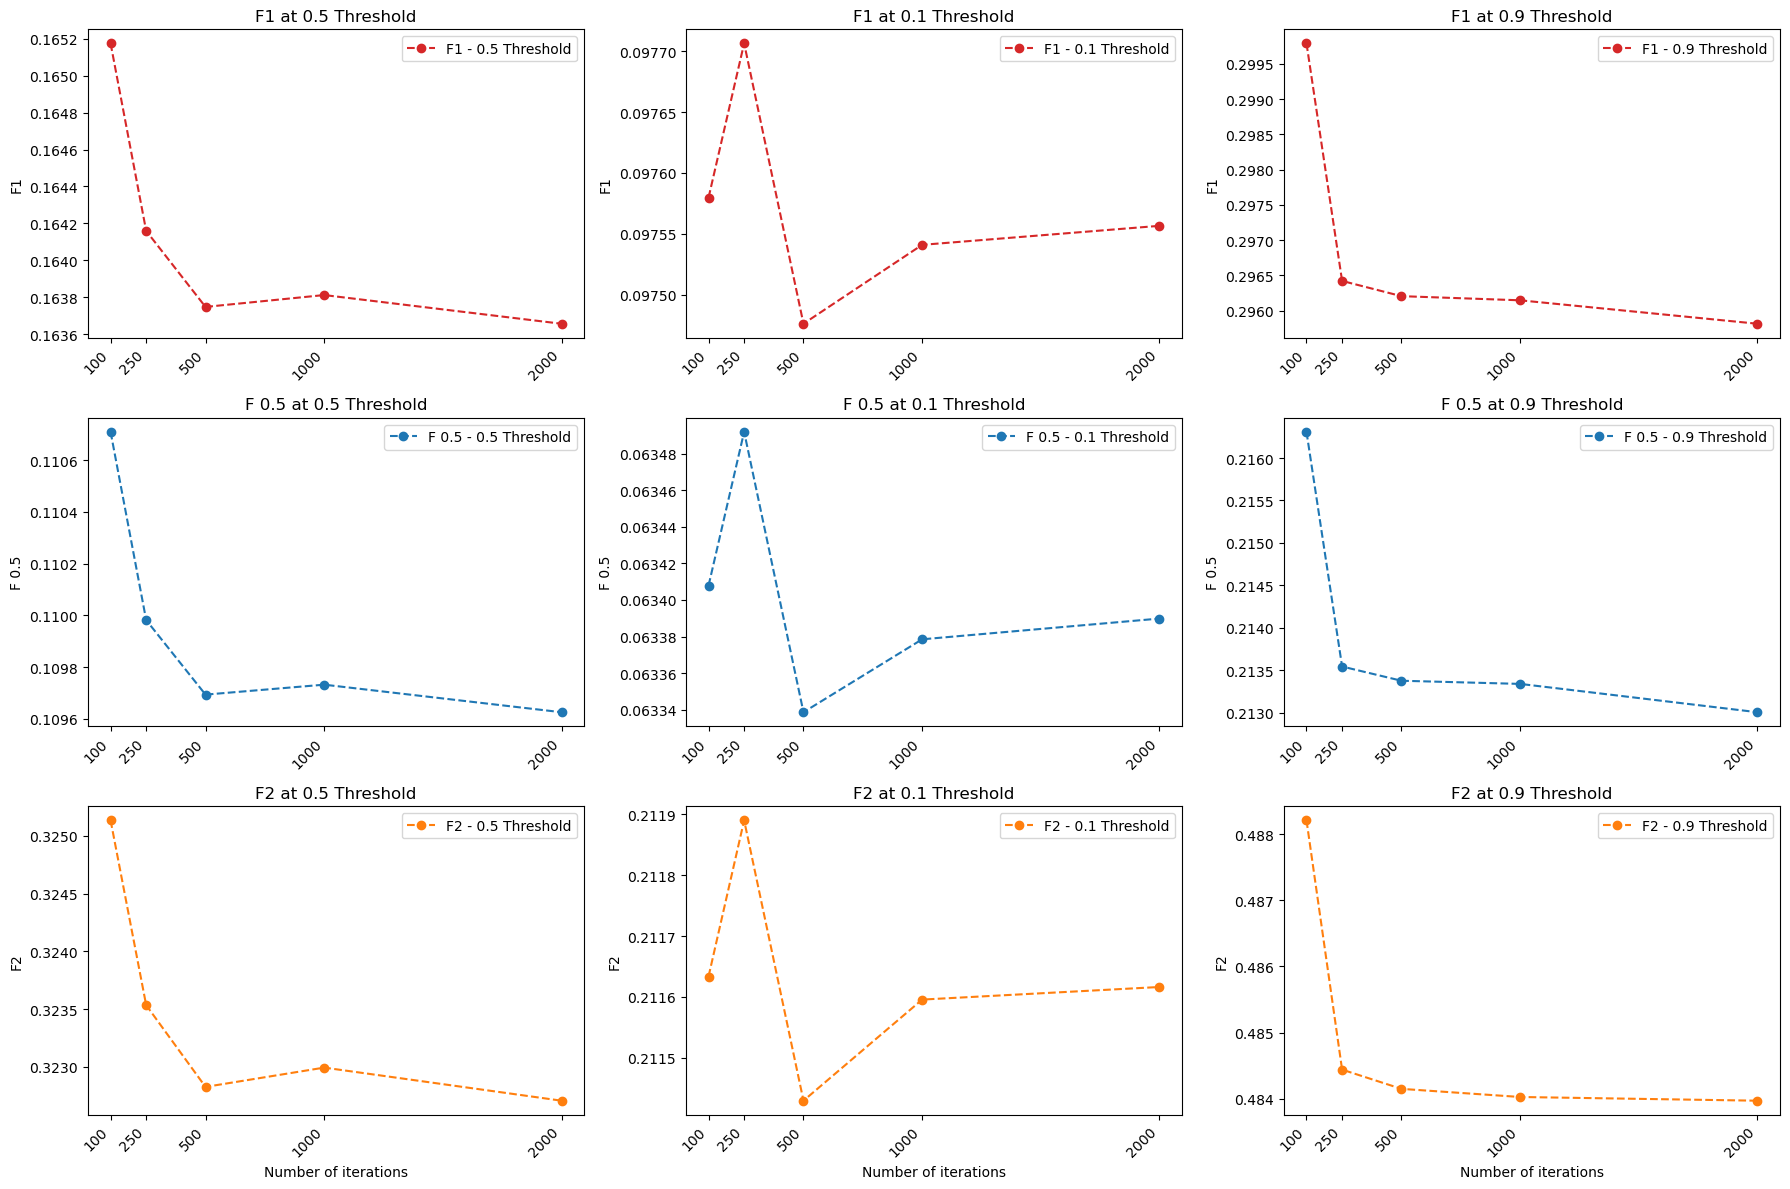

In [53]:
# Create a figure and set of subplots
plt.figure(figsize=(18, 12))

# Plot for F1 scores at 0.5 threshold
plt.subplot(3, 3, 1)  # (rows, cols, subplot_index)
plt.plot(iterations,f1_scores, marker = 'o',color='tab:red' ,linestyle = '--', label = 'F1 - 0.5 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.ylabel('F1')
plt.title('F1 at 0.5 Threshold')
plt.legend(loc='best')

# Plot for F1 scores at 0.1 threshold
plt.subplot(3, 3, 2)
plt.plot(iterations,f1_scores_01, marker = 'o',color='tab:red' ,linestyle = '--', label = 'F1 - 0.1 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.ylabel('F1')
plt.title('F1 at 0.1 Threshold')
plt.legend(loc='best');

# Plot for F1 scores at 0.9 threshold
plt.subplot(3, 3, 3)
plt.plot(iterations,f1_scores_09, marker = 'o',color='tab:red' ,linestyle = '--', label = 'F1 - 0.9 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.ylabel('F1')
plt.title('F1 at 0.9 Threshold')
plt.legend(loc='best');

# Plot for F05 scores at 0.5 threshold
plt.subplot(3, 3, 4)
plt.plot(iterations,f05_scores, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'F 0.5 - 0.5 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.ylabel('F 0.5')
plt.title('F 0.5 at 0.5 Threshold')
plt.legend(loc='best');

# Plot for F05 scores at 0.1 threshold
plt.subplot(3, 3, 5)
plt.plot(iterations,f05_scores_01, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'F 0.5 - 0.1 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.ylabel('F 0.5')
plt.title('F 0.5 at 0.1 Threshold')
plt.legend(loc='best');

# Plot for F05 scores at 0.9 threshold
plt.subplot(3, 3, 6)
plt.plot(iterations,f05_scores_09, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'F 0.5 - 0.9 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.ylabel('F 0.5')
plt.title('F 0.5 at 0.9 Threshold')
plt.legend(loc='best');


# Plot for F2 scores at 0.5 threshold
plt.subplot(3, 3, 7)
plt.plot(iterations,f2_scores, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'F2 - 0.5 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('F2')
plt.title('F2 at 0.5 Threshold')
plt.legend(loc='best');

# Plot for F2 scores at 0.1 threshold
plt.subplot(3, 3, 8)
plt.plot(iterations,f2_scores_01, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'F2 - 0.1 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('F2')
plt.title('F2 at 0.1 Threshold')
plt.legend(loc='best');

# Plot for F05 scores at 0.9 threshold
plt.subplot(3, 3, 9)
plt.plot(iterations,f2_scores_09, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'F2 - 0.9 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('F2')
plt.title('F2 at 0.9 Threshold')
plt.legend(loc='best');


plt.tight_layout()
plt.show()

Similar story here. The scores are not very good and the movements across iterations are not large. 

### <a id='toc11_2_4_'></a>[MCC Scores](#toc0_)

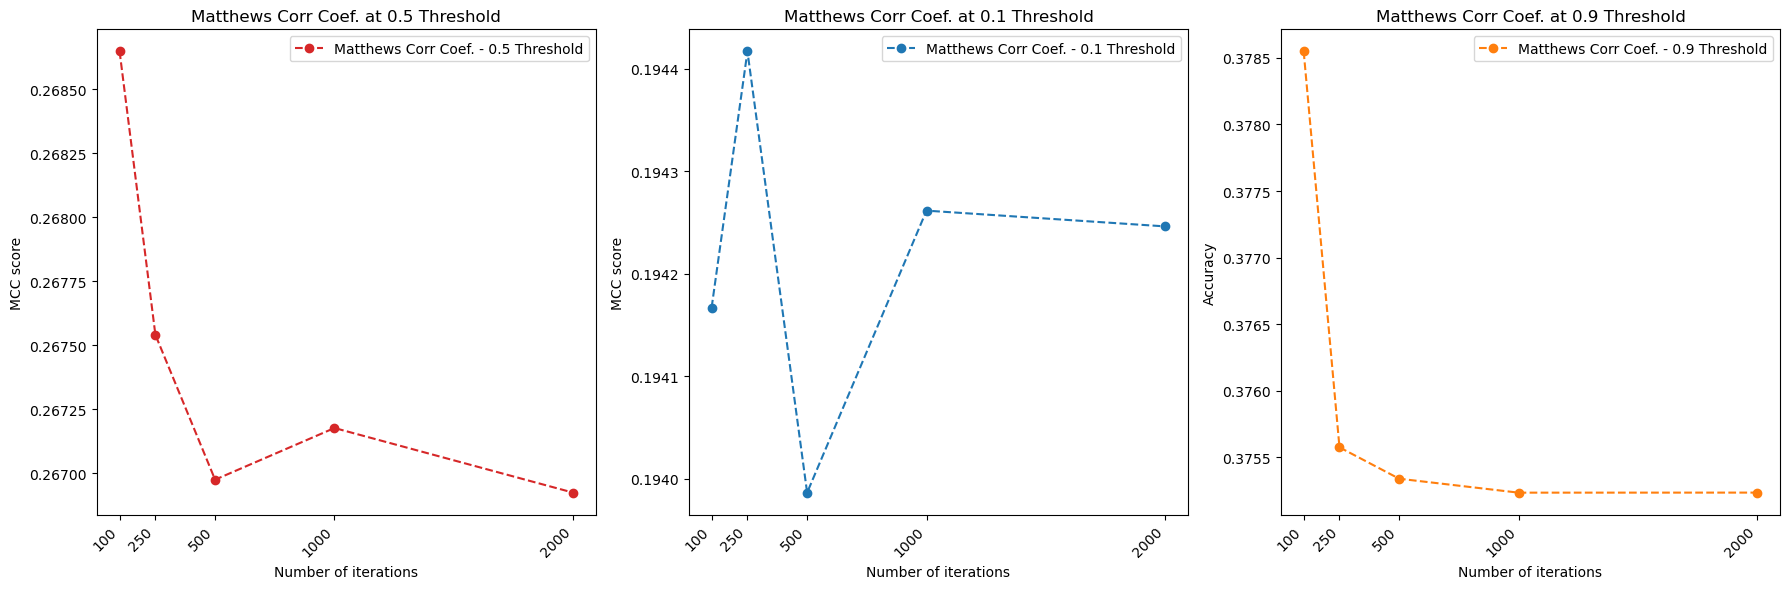

In [54]:
# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for MCC scores at 0.5 threshold
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(iterations,matthews_corrcoef_scores, marker = 'o',color = 'tab:red' ,linestyle = '--',  label = 'Matthews Corr Coef. - 0.5 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('MCC score')
plt.title('Matthews Corr Coef. at 0.5 Threshold')
plt.legend(loc='best')

# Plot for MCC scores at 0.1 threshold
plt.subplot(1, 3, 2)
plt.plot(iterations,matthews_corrcoef_scores_01, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Matthews Corr Coef. - 0.1 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('MCC score')
plt.title('Matthews Corr Coef. at 0.1 Threshold')
plt.legend(loc='best');

# Plot for MCC scores at 0.1 threshold
plt.subplot(1, 3, 3)
plt.plot(iterations,matthews_corrcoef_scores_09, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'Matthews Corr Coef. - 0.9 Threshold')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Matthews Corr Coef. at 0.9 Threshold')
plt.legend(loc='best');

plt.tight_layout()
plt.show()

Same thing for the MCC scores. 

# <a id='toc12_'></a>[Time windows applied to positive class only](#toc0_)

In this section I'll be applying a similar modeling approach but adding in undersampling of the majority class. 
The data here will consists of various subsets of the positive class based on the time a partocular blood test was taken prior to ICU admission. 
The negative class stays unchanged and is then undersampled. See feature engineering notebook for details on how the data was subset,

## <a id='toc12_1_'></a>[Import data](#toc0_)

In [56]:
leipzig_positive_class_6hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_6_hrs_to_ICU.csv', index_col = 0)

In [57]:
leipzig_positive_class_6hrs_to_ICU.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,...,RBC_cumulative_mean,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2
0,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,...,4.36,4.36,0.0,4.36,4.36,7.3,7.3,0.0,7.3,7.3
1,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,...,6.02,6.02,0.0,6.02,6.02,4.7,4.7,0.0,4.7,4.7
2,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,...,4.37,4.37,0.0,4.37,4.37,7.1,7.1,0.0,7.1,7.1
3,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,...,4.79,4.79,0.0,4.79,4.79,5.3,5.3,0.0,5.3,5.3
4,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,...,3.96,3.96,0.0,3.96,3.96,20.9,20.9,0.0,20.9,20.9


### <a id='toc12_1_1_'></a>[Drop uneeded columns](#toc0_)

In [58]:
cols_to_drop = ['Id','Diagnosis','Center','SecToIcu','CRP','PCT','HrsToIcu']
leipzig_positive_class_6hrs_to_ICU.drop(columns=cols_to_drop, inplace=True)

### <a id='toc12_1_2_'></a>[Encode Sex Feature](#toc0_)

In [59]:
leipzig_positive_class_6hrs_to_ICU_encoded = pd.get_dummies(leipzig_positive_class_6hrs_to_ICU, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)

## <a id='toc12_2_'></a>[Train Test Split](#toc0_)

In [60]:
X_leipzig_6hrs_to_ICU = leipzig_positive_class_6hrs_to_ICU_encoded .drop(columns = ['Class'])
y_leipzig_6hrs_to_ICU  = leipzig_positive_class_6hrs_to_ICU_encoded ['Class']

X_train_6hrs_to_ICU, X_test_6hrs_to_ICU, y_train_6hrs_to_ICU, y_test_6hrs_to_ICU = train_test_split(X_leipzig_6hrs_to_ICU, y_leipzig_6hrs_to_ICU, test_size=0.2, random_state=42, stratify=y_leipzig_6hrs_to_ICU)

In [61]:
print('Whole dataframe:')
check_binary_labels_ratio(leipzig_positive_class_6hrs_to_ICU,'Class')
print('\n')

print('Training set:')
check_binary_labels_ratio(y_train_6hrs_to_ICU)
print('\n')

print('Test Set:')
check_binary_labels_ratio(y_test_6hrs_to_ICU)

Whole dataframe:
Class counts:
 Class
0    1364704
1       2016
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 676.936507936508

Class percentages:
 Class
0    99.852494
1     0.147506
Name: count, dtype: float64


Training set:
Class counts:
 Class
0    1091763
1       1613
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 676.8524488530688

Class percentages:
 Class
0    99.852475
1     0.147525
Name: count, dtype: float64


Test Set:
Class counts:
 Class
0    272941
1       403
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 677.272952853598

Class percentages:
 Class
0    99.852567
1     0.147433
Name: count, dtype: float64


## <a id='toc12_3_'></a>[XGBoost Model](#toc0_)

In [62]:
# Create an XGBoost model
model = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)

# Train the model
model.fit(X_train_6hrs_to_ICU, y_train_6hrs_to_ICU)

# Make predictions
y_pred_6hrs_to_ICU = model.predict(X_test_6hrs_to_ICU)
y_pred_prob_6hrs_to_ICU = model.predict_proba(X_test_6hrs_to_ICU)[:, 1]  # Probability estimates for positive class


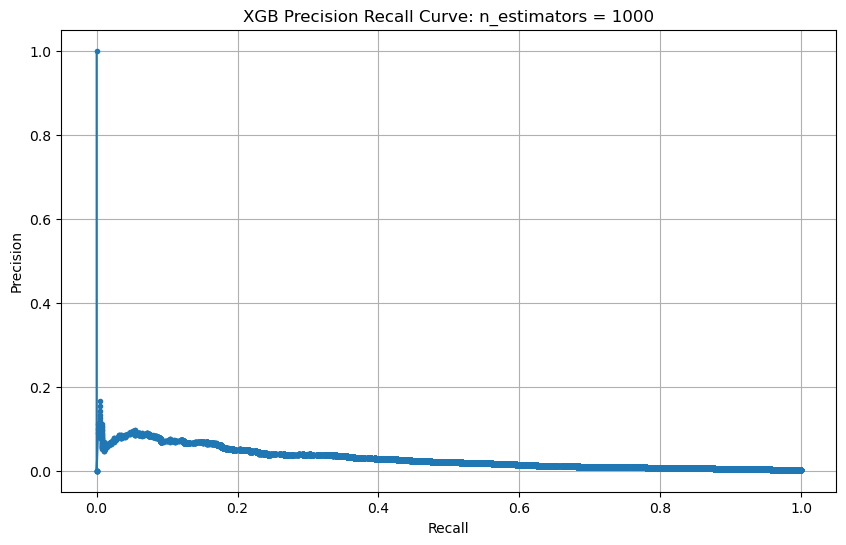

In [63]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_6hrs_to_ICU, y_pred_prob_6hrs_to_ICU)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Precision Recall Curve: n_estimators = 1000')
plt.grid()
plt.show()

This is not a good curve at all. Not too suprising since the positive class is smaller based on the subsetting, but the negative class is unchanged. 
By doing that I've made the class imbalance worse. 

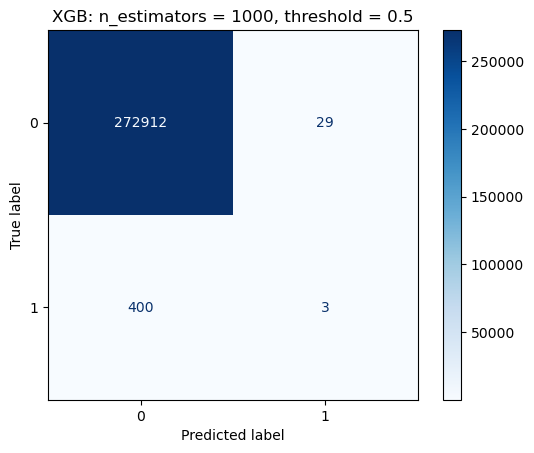

Accuracy: 0.9953524063242022
Precision: 0.9710078232857801
Recall: 0.6334434103872711
F1: 0.7667151162790699
F05: 0.8774848207602096
F2: 0.6807769245660451
Matthews Corr Coef: 0.7823258108782376


In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test_6hrs_to_ICU, y_pred_6hrs_to_ICU)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGB: n_estimators = 1000, threshold = 0.5')
plt.show()

threshold_05_scores = create_classifier_scores_object(y_test, y_pred, print_results=True)

## <a id='toc12_4_'></a>[Try various Thresholds](#toc0_)

In [65]:
#Run a loop of different threasholds to see how they affect things with the XGBoost Model.

scores_6hrs_to_ICU = {
    'Accuracy':[],
    'Precison': [],
    'Recall': [],
    'F1': [],
    'F0.5': [],
    'F2': [],
    'Matthews Coef.': []
}

threshold_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for value in threshold_values:

    #Run the model
    model = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)

    # Train the model
    model.fit(X_train_6hrs_to_ICU, y_train_6hrs_to_ICU)

    # Make predictions based on threshold
    y_pred_6hrs_to_ICU = model.predict(X_test_6hrs_to_ICU)
    y_pred_prob_6hrs_to_ICU = model.predict_proba(X_test_6hrs_to_ICU)[:, 1]  # Probability estimates for positive class 
    y_pred_custom_6hrs_to_ICU = (y_pred_prob_6hrs_to_ICU >= value).astype(int)
 
    scores_object = create_classifier_scores_object(y_test_6hrs_to_ICU,  y_pred_custom_6hrs_to_ICU, print_results = False)

    scores_6hrs_to_ICU['Accuracy'].append(round(scores_object.accuracy,5))
    scores_6hrs_to_ICU['Precison'].append(round(scores_object.precision,5))
    scores_6hrs_to_ICU['Recall'].append(round(scores_object.recall,5))
    scores_6hrs_to_ICU['F1'].append(round(scores_object.f1,5))
    scores_6hrs_to_ICU['F0.5'].append(round(scores_object.f05,5))
    scores_6hrs_to_ICU['F2'].append(round(scores_object.f2,5))
    scores_6hrs_to_ICU['Matthews Coef.'].append(round(scores_object.mcc,5))

In [66]:
scores_6hrs_to_ICU['Accuracy']
scores_6hrs_to_ICU['F1']
scores_6hrs_to_ICU['Recall']

[0.03474, 0.00993, 0.00744, 0.00744, 0.00744, 0.00496, 0.00496, 0.00248, 0.0]

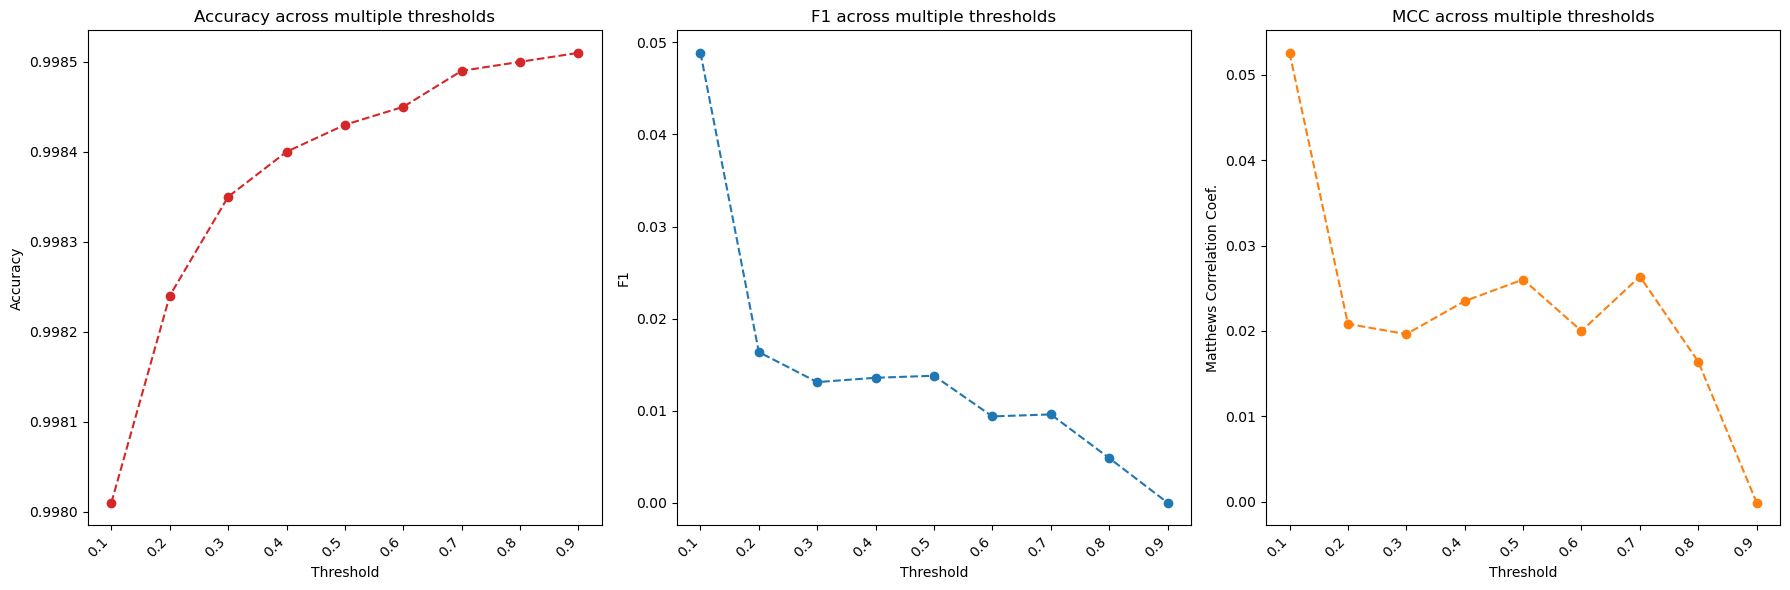

In [67]:
#Visualize Accuracy, F1, MCC

# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Accuracy scores
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(threshold_values,scores_6hrs_to_ICU['Accuracy'], marker = 'o',color='tab:red' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy across multiple thresholds')


# Plot for F1 Scores
plt.subplot(1, 3, 2)
plt.plot(threshold_values,scores_6hrs_to_ICU['F1'], marker = 'o',color='tab:blue' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 across multiple thresholds')


# Plot for MCC Scores
plt.subplot(1, 3, 3)
plt.plot(threshold_values,scores_6hrs_to_ICU['Matthews Coef.'], marker = 'o',color='tab:orange' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Matthews Correlation Coef.')
plt.title('MCC across multiple thresholds')


plt.tight_layout()
plt.show()

Some movement, but the overall numbers are still quite bad. 

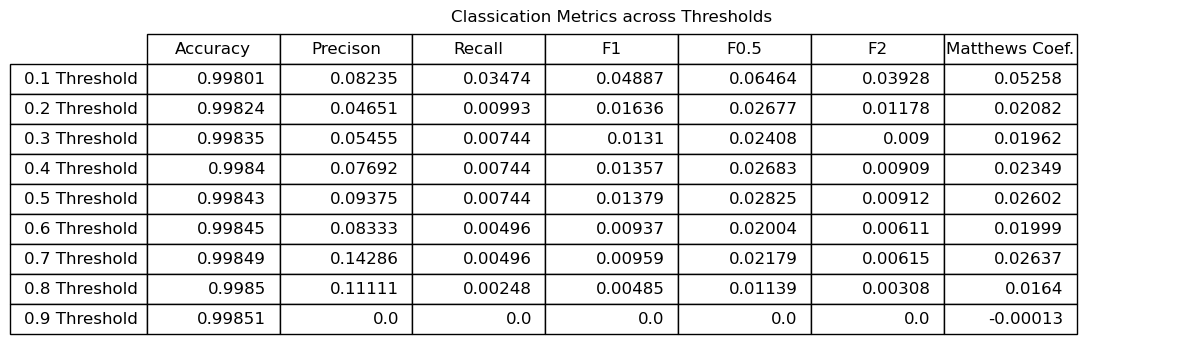

In [68]:
df = pd.DataFrame(scores_6hrs_to_ICU, index=[str(x) + ' Threshold' for x in threshold_values])

# Plot a table
fig, ax = plt.subplots(figsize=(15, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

plt.title('Classication Metrics across Thresholds')
 
plt.show()

The above results are terrible. But I think that's because the number of positive samples has been drastically reduced by imposing the 6 hour from ICU window on the data. 
There were about 16,000 positive class examples before subsetting the positive class. Now there are 2016 examples. So a reduction in the positvie class of roughly 8x. 

Let's see if that can be corrected by doing the same basic think as above on this data subset, but applying undersampling of the negative class. 
I'll do that below using the XGB_majority_vote function from above and setting the iterations to 1. 

## <a id='toc12_5_'></a>[Undersampling with XGBoost](#toc0_)

In [69]:
#keep the default threshold and run multiple iteration options to see the effect on the classification metrics.

accuracy_scores = []
precision_scores= []
recall_scores = []
f1_scores = []
f05_scores = []
f2_scores = []
matthews_corrcoef_scores = []


for value in threshold_values:
    print(value)
    matrix_6hrs_to_ICU = XGB_majority_vote(X_train_6hrs_to_ICU, y_train_6hrs_to_ICU, X_test_6hrs_to_ICU, iter = 1,threshold = value, sampling_strategy = 'auto')
    scores = create_classifier_scores_object(y_test_6hrs_to_ICU, matrix_6hrs_to_ICU['Majority_vote'], print_results=False)

    accuracy_scores.append(scores.accuracy)
    precision_scores.append(scores.precision)
    recall_scores.append(scores.recall)
    f1_scores.append(scores.f1)
    f05_scores.append(scores.f05)
    f2_scores.append(scores.f2) 
    matthews_corrcoef_scores.append(scores.mcc)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


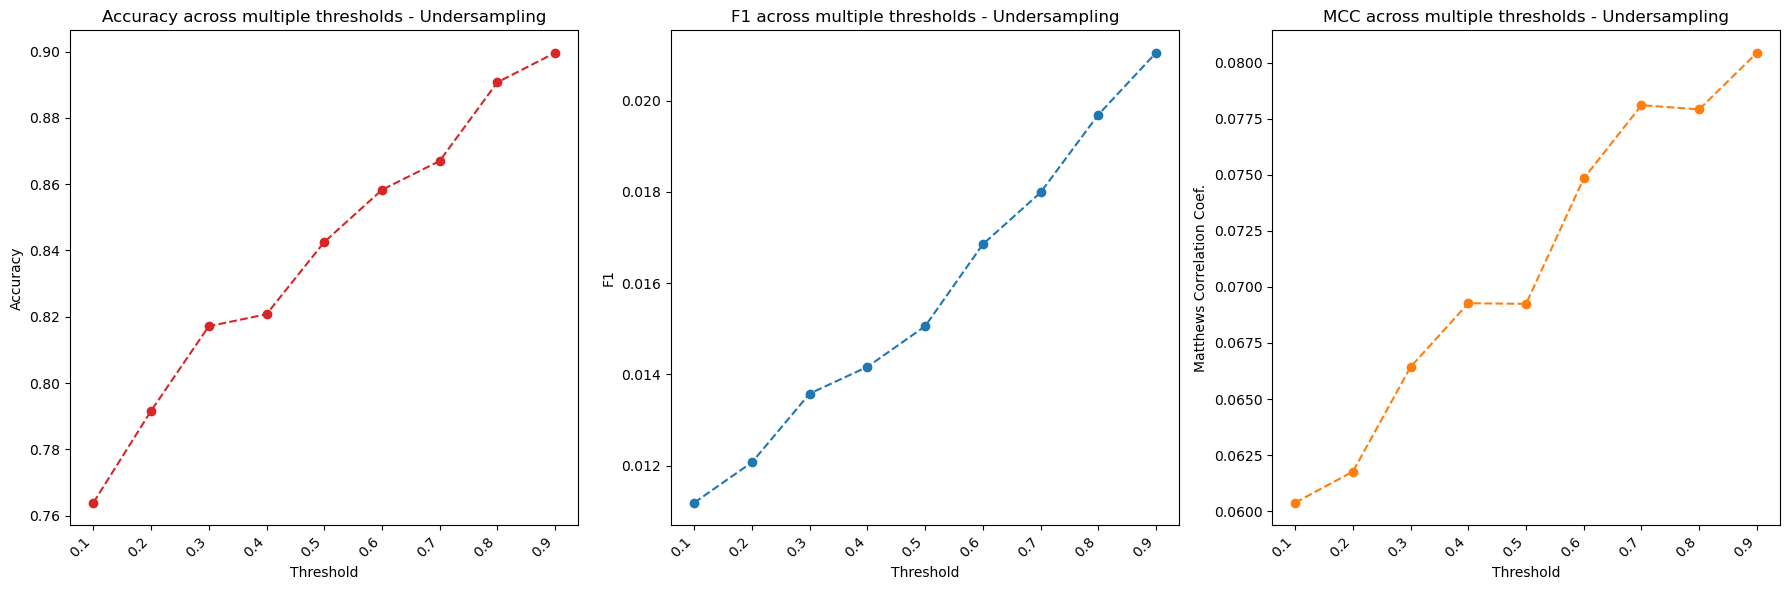

In [70]:
#Visualize Accuracy, F1, MCC

# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Accuracy scores
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(threshold_values,accuracy_scores, marker = 'o',color='tab:red' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy across multiple thresholds - Undersampling')


# Plot for F1 Scores
plt.subplot(1, 3, 2)
plt.plot(threshold_values,f1_scores, marker = 'o',color='tab:blue' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 across multiple thresholds - Undersampling')


# Plot for MCC Scores
plt.subplot(1, 3, 3)
plt.plot(threshold_values,matthews_corrcoef_scores, marker = 'o',color='tab:orange' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Matthews Correlation Coef.')
plt.title('MCC across multiple thresholds - Undersampling')


plt.tight_layout()
plt.show()

Still not great results here, even with the undersampling, but it could be that the random under sample here wasn't very good, or just wasn't enough. 

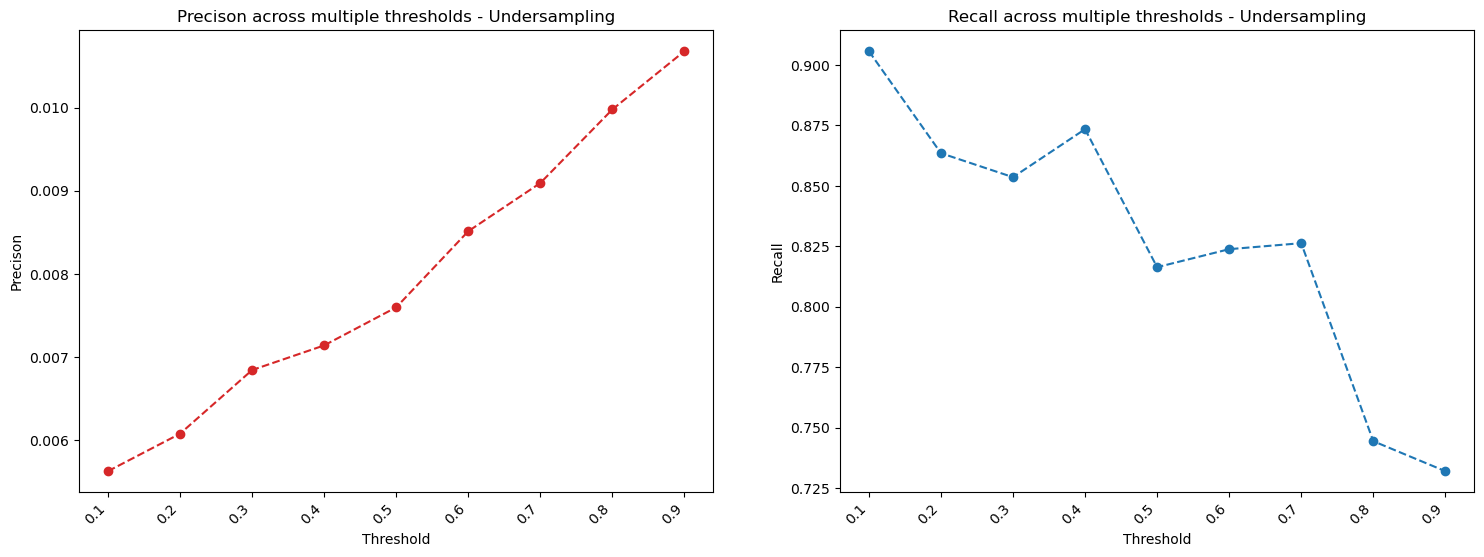

In [71]:
#Visualize Precison and Recall

# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Precision scores
plt.subplot(1, 2, 1)  # (rows, cols, subplot_index)
plt.plot(threshold_values,precision_scores, marker = 'o',color='tab:red' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Precison')
plt.title('Precison across multiple thresholds - Undersampling')


# Plot for Recall Scores
plt.subplot(1, 2, 2)
plt.plot(threshold_values,recall_scores, marker = 'o',color='tab:blue' ,linestyle = '--')
plt.xticks(threshold_values, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall across multiple thresholds - Undersampling');



In [72]:
#Precison Recall Curve for this scenario
y_pred_prob_iter_1 = XGB_majority_vote(X_train_6hrs_to_ICU, y_train_6hrs_to_ICU, X_test_6hrs_to_ICU, iter = 1,threshold = 0.5, sampling_strategy = 'auto', return_matrix = False,return_y_pred_prob=True)

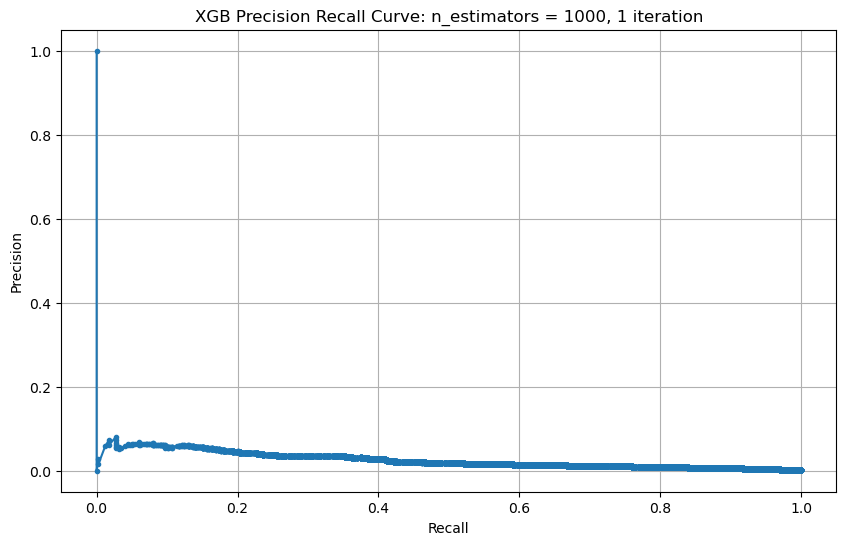

In [73]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_6hrs_to_ICU, y_pred_prob_iter_1['Majority_vote'])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Precision Recall Curve: n_estimators = 1000, 1 iteration')
plt.grid()
plt.show()

## <a id='toc12_6_'></a>[Undersampling and Majority Vote with XGBoost](#toc0_)

Let's see if running the undersampling process many times provides any benefit. This is a computatonally intensive process, I'll try for a 0.5 threshold first. 

In [74]:
#keep the default threshold and run multiple iteration options to see the effect on the classification metrics.

iterations = [100,250,500,1000,2000]

accuracy_scores_6hrs_to_ICU = []
precision_scores_6hrs_to_ICU= []
recall_scores_6hrs_to_ICU = []
f1_scores_6hrs_to_ICU = []
f05_scores_6hrs_to_ICU = []
f2_scores_6hrs_to_ICU = []
matthews_corrcoef_scores_6hrs_to_ICU = []


for iteration in iterations:
    print(iteration)
    matrix = XGB_majority_vote(X_train_6hrs_to_ICU, y_train_6hrs_to_ICU, X_test_6hrs_to_ICU, iter = iteration,threshold = 0.5, sampling_strategy = 'auto')
    scores = create_classifier_scores_object(y_test_6hrs_to_ICU, matrix['Majority_vote'], print_results=False)

    accuracy_scores_6hrs_to_ICU.append(scores.accuracy)
    precision_scores_6hrs_to_ICU.append(scores.precision)
    recall_scores_6hrs_to_ICU.append(scores.recall)
    f1_scores_6hrs_to_ICU.append(scores.f1)
    f05_scores_6hrs_to_ICU.append(scores.f05)
    f2_scores_6hrs_to_ICU.append(scores.f2) 
    matthews_corrcoef_scores_6hrs_to_ICU.append(scores.mcc)

100
250
500
1000
2000


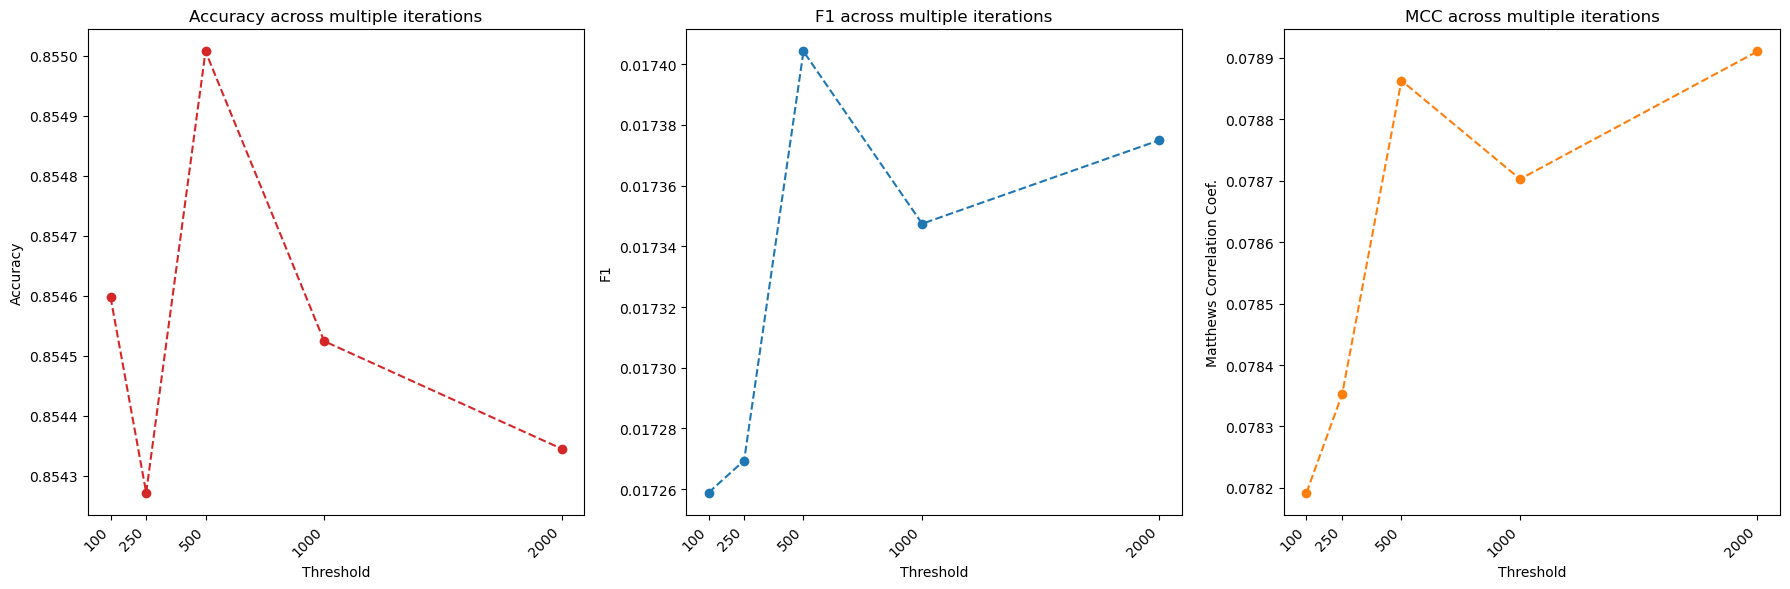

In [75]:
# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Accuracy scores
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(iterations,accuracy_scores_6hrs_to_ICU, marker = 'o',color='tab:red' ,linestyle = '--')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy across multiple iterations')


# Plot for F1 Scores
plt.subplot(1, 3, 2)
plt.plot(iterations,f1_scores_6hrs_to_ICU, marker = 'o',color='tab:blue' ,linestyle = '--')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 across multiple iterations')


# Plot for MCC Scores
plt.subplot(1, 3, 3)
plt.plot(iterations,matthews_corrcoef_scores_6hrs_to_ICU, marker = 'o',color='tab:orange' ,linestyle = '--')
plt.xticks(iterations, rotation=45, ha='right')
plt.xlabel('Threshold')
plt.ylabel('Matthews Correlation Coef.')
plt.title('MCC across multiple iterations')


plt.tight_layout()
plt.show()

In [76]:
y_pred_prob_iter_250 = XGB_majority_vote(X_train_6hrs_to_ICU, y_train_6hrs_to_ICU, X_test_6hrs_to_ICU, iter = 250,threshold = 0.5, sampling_strategy = 'auto', return_matrix = False,return_y_pred_prob=True)


#def XGB_majority_vote(X_train, y_train, X_test, iter,threshold = 0.5, sampling_strategy = 'auto', return_matrix = True, return_y_pred_prob = False):

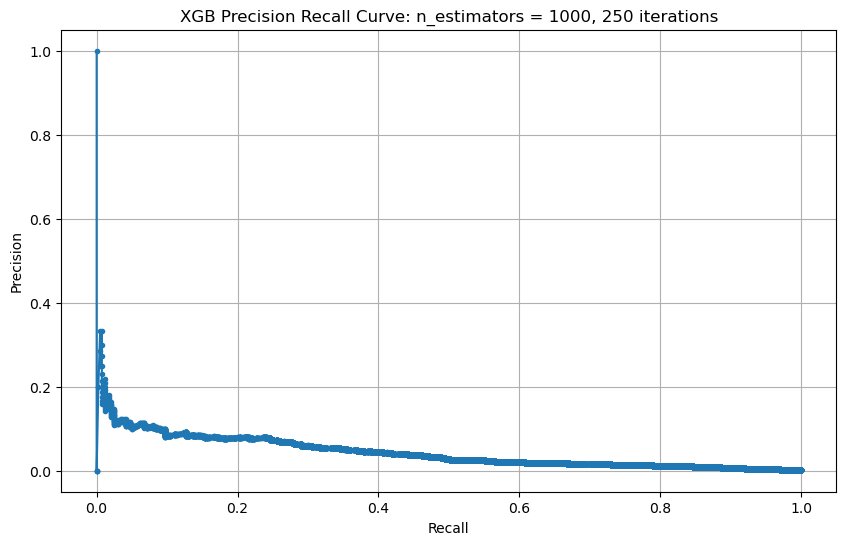

In [77]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_6hrs_to_ICU, y_pred_prob_iter_250['Majority_vote'])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Precision Recall Curve: n_estimators = 1000, 250 iterations')
plt.grid()
plt.show()

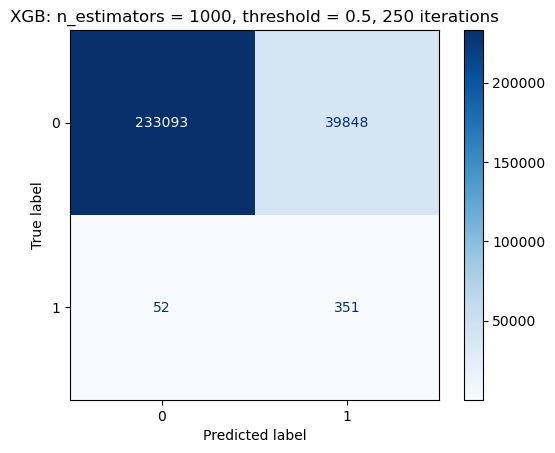

In [78]:
# Confusion Matrix

y_pred_binary = np.where(y_pred_prob_iter_250['Majority_vote'] >= 0.5, 1, 0)

cm = confusion_matrix(y_test_6hrs_to_ICU, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues,values_format='d')
plt.title('XGB: n_estimators = 1000, threshold = 0.5, 250 iterations')
plt.show()

In [79]:
create_classifier_scores_object(y_test_6hrs_to_ICU,y_pred_binary,print_results=True);

Accuracy: 0.8540300866307656
Precision: 0.008731560486579268
Recall: 0.8709677419354839
F1: 0.01728978868036057
F05: 0.0108871643124337
F2: 0.04197459998564971
Matthews Corr Coef: 0.0785394687121728


In [80]:
y_pred_prob_iter_500 = XGB_majority_vote(X_train_6hrs_to_ICU, y_train_6hrs_to_ICU, X_test_6hrs_to_ICU, iter = 2,threshold = 0.95, sampling_strategy = 'auto', return_matrix = True,return_y_pred_prob=False)

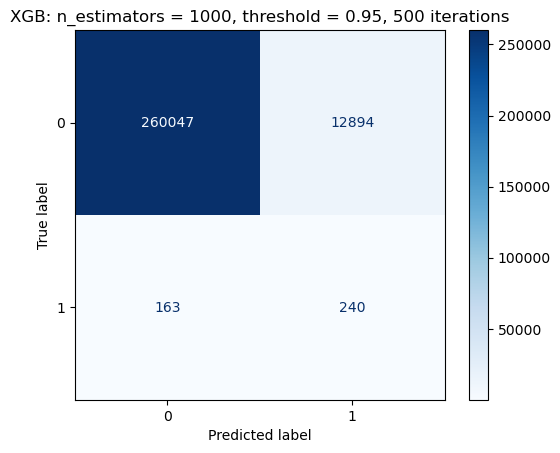

In [81]:
cm = confusion_matrix(y_test_6hrs_to_ICU, y_pred_prob_iter_500['Majority_vote'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues,values_format='d')
plt.title('XGB: n_estimators = 1000, threshold = 0.95, 500 iterations')
plt.show()

In [82]:
create_classifier_scores_object(y_test_6hrs_to_ICU,y_pred_prob_iter_500['Majority_vote'],print_results=True);

Accuracy: 0.9522323519082182
Precision: 0.01827318410232983
Recall: 0.5955334987593052
F1: 0.0354583733471227
F05: 0.022667598556829555
F2: 0.08137800081378001
Matthews Corr Coef: 0.09836457866016499


These are not good scores. The multiple iterations don't seem to be improving performance, and the undersampling doesn't seem to be helping either, at least in the 6 hour window. 
I'll try multiple windows below and see if increasing the size of the minority class by increasing the size of the window from ICU helps. 

# <a id='toc13_'></a>[Undersampling and Majority Vote Across multiple time windows.](#toc0_)

With the results from the 0-6 hours from ICU window being so poor, I'm going to try modeling multipple time windows, starting at 6 hours and moveing by 6 hour increments.
This should shed some light on how the subsetting of the data in this way is effecting the models. 

In [83]:
#Import multiple time window dataframes
hrsToIcu_df_dict = {}


leipzig_positive_class_6hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_6_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['6hrs_to_ICU'] = leipzig_positive_class_6hrs_to_ICU
leipzig_positive_class_12hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_12_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['12hrs_to_ICU'] = leipzig_positive_class_12hrs_to_ICU
#leipzig_positive_class_18hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_18_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['18hrs_to_ICU'] = leipzig_positive_class_18hrs_to_ICU
leipzig_positive_class_24hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_24_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['24hrs_to_ICU'] = leipzig_positive_class_24hrs_to_ICU
#leipzig_positive_class_30hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_30_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['30hrs_to_ICU'] = leipzig_positive_class_30hrs_to_ICU
#leipzig_positive_class_36hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_36_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['36hrs_to_ICU'] = leipzig_positive_class_36hrs_to_ICU
#leipzig_positive_class_42hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_42_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['42hrs_to_ICU'] = leipzig_positive_class_42hrs_to_ICU
leipzig_positive_class_48hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_48_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['48hrs_to_ICU'] = leipzig_positive_class_48hrs_to_ICU
#leipzig_positive_class_54hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_54_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['54hrs_to_ICU'] = leipzig_positive_class_54hrs_to_ICU
#leipzig_positive_class_60hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_60_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['60hrs_to_ICU'] = leipzig_positive_class_60hrs_to_ICU
#leipzig_positive_class_66hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_66_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['66hrs_to_ICU'] = leipzig_positive_class_66hrs_to_ICU
leipzig_positive_class_72hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_72_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['72hrs_to_ICU'] = leipzig_positive_class_72hrs_to_ICU
#leipzig_positive_class_78hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_78_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['78hrs_to_ICU'] = leipzig_positive_class_78hrs_to_ICU
#leipzig_positive_class_84hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_84_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['84hrs_to_ICU'] = leipzig_positive_class_84hrs_to_ICU
#leipzig_positive_class_90hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_90_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['90hrs_to_ICU'] = leipzig_positive_class_90hrs_to_ICU
leipzig_positive_class_96hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_96_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['96hrs_to_ICU'] = leipzig_positive_class_96hrs_to_ICU
#leipzig_positive_class_102hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_102_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['102hrs_to_ICU'] = leipzig_positive_class_102hrs_to_ICU
#leipzig_positive_class_108hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_108_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['108hrs_to_ICU'] = leipzig_positive_class_108hrs_to_ICU
#leipzig_positive_class_114hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_114_hrs_to_ICU.csv', index_col = 0)
#hrsToIcu_df_dict['114hrs_to_ICU'] = leipzig_positive_class_114hrs_to_ICU

leipzig_positive_class_120hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_120_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['120hrs_to_ICU'] = leipzig_positive_class_120hrs_to_ICU

leipzig_positive_class_168hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_168_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['168hrs_to_ICU'] = leipzig_positive_class_168hrs_to_ICU

leipzig_positive_class_336hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_336_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['336hrs_to_ICU'] = leipzig_positive_class_336hrs_to_ICU

leipzig_positive_class_504hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_504_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['504hrs_to_ICU'] = leipzig_positive_class_504hrs_to_ICU

leipzig_positive_class_744hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_744_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['744hrs_to_ICU'] = leipzig_positive_class_744hrs_to_ICU

leipzig_positive_class_840hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_840_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['840hrs_to_ICU'] = leipzig_positive_class_840hrs_to_ICU

leipzig_positive_class_1008hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_1008_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['1008hrs_to_ICU'] = leipzig_positive_class_1008hrs_to_ICU

leipzig_positive_class_1176hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_1176_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['1176hrs_to_ICU'] = leipzig_positive_class_1176hrs_to_ICU

leipzig_positive_class_1344hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_1344_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['1344hrs_to_ICU'] = leipzig_positive_class_1344hrs_to_ICU

leipzig_positive_class_2016hrs_to_ICU = pd.read_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_2016_hrs_to_ICU.csv', index_col = 0)
hrsToIcu_df_dict['2016hrs_to_ICU'] = leipzig_positive_class_2016hrs_to_ICU

leipzig_full_data = pd.read_csv('../data/processed/data_with_engineered_features/leipzig_full_data_with_engineered_features.csv', index_col = 0)
hrsToIcu_df_dict['All_hrs_to_ICU'] = leipzig_full_data

In [84]:
#Prep the data for modeling

hrsToIcu_df_dict_scores_majority_vote = {}

for key in hrsToIcu_df_dict.keys():

    #count and print the iteration
    print(key)

    df = hrsToIcu_df_dict[key]
    
    #drop columns and encode
    cols_to_drop = ['Id','Diagnosis','Center','SecToIcu','CRP','PCT','HrsToIcu']
    df_dropped = df.drop(columns=cols_to_drop)

    df_encoded = pd.get_dummies(df_dropped, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)

    #train test split
    X_df = df_encoded.drop(columns = ['Class'])
    y_df  = df_encoded['Class']

    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

    #Generate voting matrix and scores object
    matrix = XGB_majority_vote(X_train, y_train, X_test, iter = 100,threshold = 0.5, sampling_strategy = 'auto', return_matrix=True)
    scores = create_classifier_scores_object(y_test, matrix['Majority_vote'], print_results=False)

    #save scores object
    scores_key = key + '_scores'
    hrsToIcu_df_dict_scores_majority_vote[scores_key] = scores

6hrs_to_ICU
12hrs_to_ICU
24hrs_to_ICU
48hrs_to_ICU
72hrs_to_ICU
96hrs_to_ICU
120hrs_to_ICU
168hrs_to_ICU
336hrs_to_ICU
504hrs_to_ICU
744hrs_to_ICU
840hrs_to_ICU
1008hrs_to_ICU
1176hrs_to_ICU
1344hrs_to_ICU
2016hrs_to_ICU
All_hrs_to_ICU


In [85]:
for key in  hrsToIcu_df_dict_scores_majority_vote.keys():
    print(key,hrsToIcu_df_dict_scores_majority_vote[key].f05)

6hrs_to_ICU_scores 0.011104609828680721
12hrs_to_ICU_scores 0.013567772038187322
24hrs_to_ICU_scores 0.01528544276260047
48hrs_to_ICU_scores 0.018617745890473162
72hrs_to_ICU_scores 0.021967052091007123
96hrs_to_ICU_scores 0.025242636241440256
120hrs_to_ICU_scores 0.02879496393331246
168hrs_to_ICU_scores 0.034274731728151195
336hrs_to_ICU_scores 0.05077200071787094
504hrs_to_ICU_scores 0.06279664765730546
744hrs_to_ICU_scores 0.0759497725671087
840hrs_to_ICU_scores 0.0801361926893525
1008hrs_to_ICU_scores 0.08572314063210926
1176hrs_to_ICU_scores 0.08988427909000665
1344hrs_to_ICU_scores 0.09404118652478359
2016hrs_to_ICU_scores 0.10216030545186153
All_hrs_to_ICU_scores 0.10943567502143325


In [102]:
#Generate data for vizualizations
num_hours = []
accuracy_scores = []
f1_scores= []
mcc_scores = []
precison = []
recall = []


for key in  hrsToIcu_df_dict_scores_majority_vote.keys():
    num_hours.append(key)
    accuracy_scores.append(hrsToIcu_df_dict_scores_majority_vote[key].accuracy)
    f1_scores.append(hrsToIcu_df_dict_scores_majority_vote[key].f1)
    mcc_scores.append(hrsToIcu_df_dict_scores_majority_vote[key].mcc)
    precison.append(hrsToIcu_df_dict_scores_majority_vote[key].precision)
    recall.append(hrsToIcu_df_dict_scores_majority_vote[key].recall)

for i in range(len(num_hours)):
    num_hours[i] = num_hours[i].split('_', 1)[0]

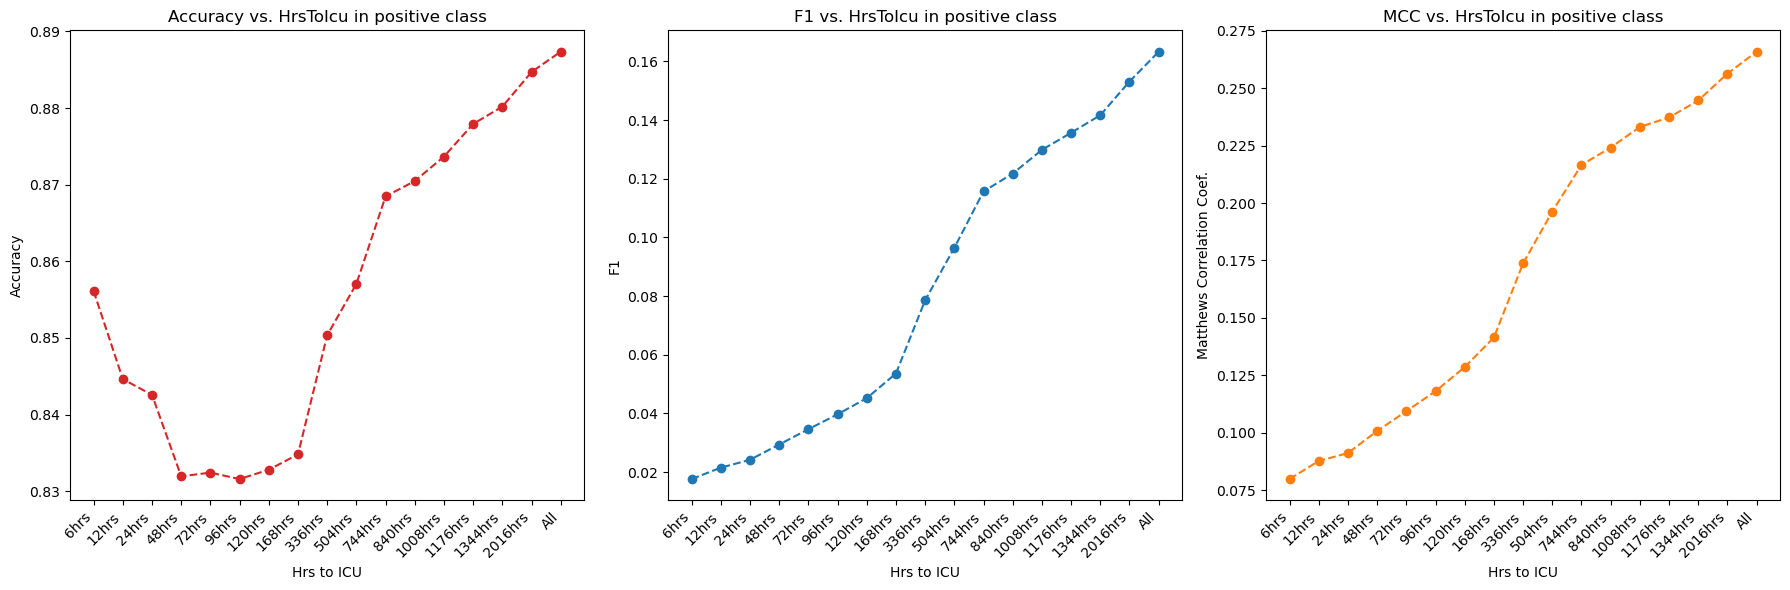

In [103]:
# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Accuracy scores
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(num_hours,accuracy_scores, marker = 'o',color='tab:red' ,linestyle = '--')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. HrsToIcu in positive class')


# Plot for F1 Scores
plt.subplot(1, 3, 2)
plt.plot(num_hours,f1_scores, marker = 'o',color='tab:blue' ,linestyle = '--')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('F1')
plt.title('F1 vs. HrsToIcu in positive class')


# Plot for MCC Scores
plt.subplot(1, 3, 3)
plt.plot(num_hours,mcc_scores, marker = 'o',color='tab:orange' ,linestyle = '--')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Matthews Correlation Coef.')
plt.title('MCC vs. HrsToIcu in positive class')


plt.tight_layout()
plt.show()

It's pretty clear that as the number of hours goes up the metrics go up. The highest metric is when all the data in the positive class is used. 

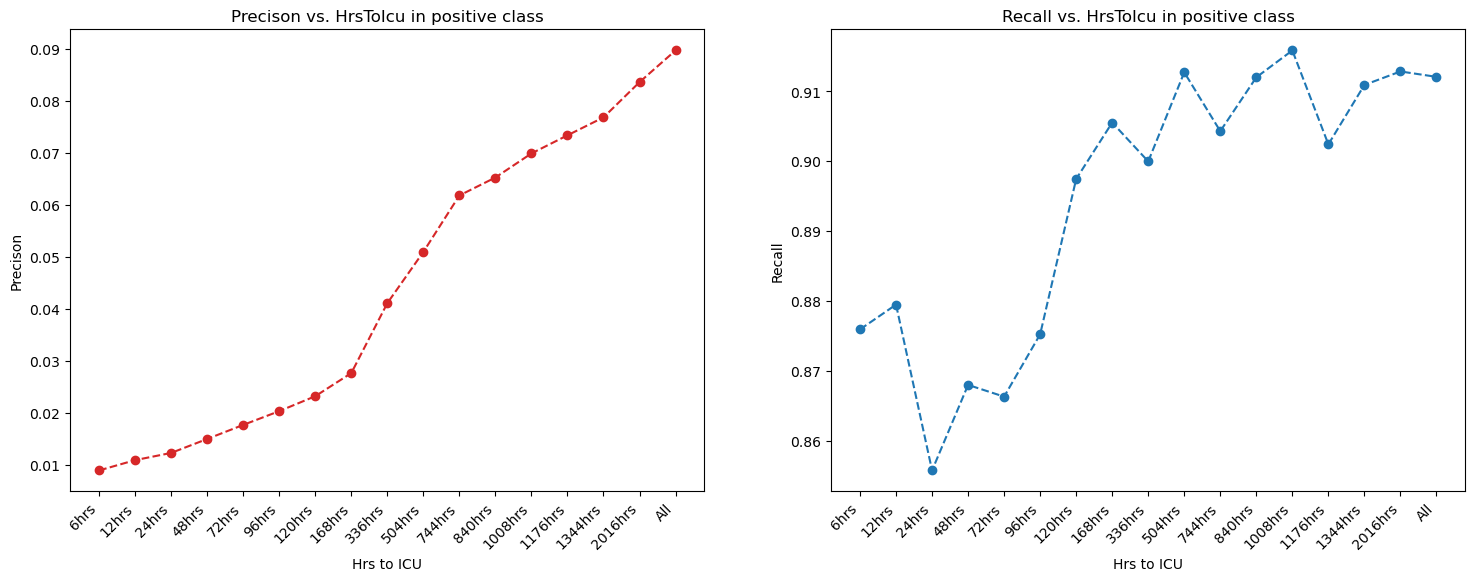

In [104]:
#Visualize Precison and Recall

# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Precision scores
plt.subplot(1, 2, 1)  # (rows, cols, subplot_index)
plt.plot(num_hours,precison, marker = 'o',color='tab:red' ,linestyle = '--')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Precison')
plt.title('Precison vs. HrsToIcu in positive class')


# Plot for Recall Scores
plt.subplot(1, 2, 2)
plt.plot(num_hours,recall, marker = 'o',color='tab:blue' ,linestyle = '--')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Recall')
plt.title('Recall vs. HrsToIcu in positive class');


Similar pattern, at least for precision, which shows improvement as the number hours goes up. The overall score is still not great. 
Interesting to know that Recall shows the same pattern, but it has much higher score than even the single model at the beginising of the notebook that
used all the data and no under-sampling. The majority vote protocol in general seems to produce very high recall scores but low precision scores and lower metrics in general.

It would seem like the majority voting is getting most of the actual positive class correct, but it's generating a lot of false positives as well.  

In [89]:
print(f'There are {len(leipzig_positive_class_2016hrs_to_ICU[leipzig_positive_class_2016hrs_to_ICU["Class"]==1])} postive class examples within 2016 hours of ICU')
print((f'There are {len(leipzig_full_data_with_engineered_features[leipzig_full_data_with_engineered_features["Class"]==1])} postive class examples in the full Leipzig data set'))

print(f'This is a difference of {16654 - 15770} cases.')

There are 15770 postive class examples within 2016 hours of ICU
There are 16654 postive class examples in the full Leipzig data set
This is a difference of 884 cases.


Based on this, subsetting on hours from ICU does nor lead to better results. The best performance is found by not subsetting at all. 

# <a id='toc14_'></a>[HrsToICU time Window - Majority vote vs. Single model - Features vs. No Features Comparison](#toc0_)

I've tried a few different approaches in the notebook above. All of which have operated on the assumption that the additional 
engineered features are adding to performance. Below I'll try to sum up all the approaches so far. I'll compare them 
based on performance with and without the additonal features. 

In [90]:
iter_counter = 1
hrsToIcu_df_dict_scores_single_model = {}

for key in hrsToIcu_df_dict.keys():

    #count and print the iteration
    print(key)

    df = hrsToIcu_df_dict[key]
    
    #drop columns and encode
    cols_to_drop = ['Id','Diagnosis','Center','SecToIcu','CRP','PCT','HrsToIcu']
    df_dropped = df.drop(columns=cols_to_drop)

    df_encoded = pd.get_dummies(df_dropped, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)

    #train test split
    X_df = df_encoded.drop(columns = ['Class'])
    y_df  = df_encoded['Class']

    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

 # Create an XGBoost model
    model = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = create_classifier_scores_object(y_test, y_pred, print_results=False)

    #save scores object
    scores_key = key + '_scores'
    hrsToIcu_df_dict_scores_single_model[scores_key] = scores

6hrs_to_ICU
12hrs_to_ICU
24hrs_to_ICU
48hrs_to_ICU
72hrs_to_ICU
96hrs_to_ICU
120hrs_to_ICU
168hrs_to_ICU
336hrs_to_ICU
504hrs_to_ICU
744hrs_to_ICU
840hrs_to_ICU
1008hrs_to_ICU
1176hrs_to_ICU
1344hrs_to_ICU
2016hrs_to_ICU
All_hrs_to_ICU


In [91]:
for key in hrsToIcu_df_dict_scores_single_model.keys():
    print(hrsToIcu_df_dict_scores_single_model[key].f1)

0.013793103448275862
0.017825311942959002
0.042042042042042045
0.09339407744874716
0.17537313432835822
0.2199367088607595
0.25724381625441695
0.3632261703327693
0.5072951739618407
0.6052709505478235
0.6399187404773997
0.6619786614936954
0.7016129032258064
0.6749335695305579
0.6989339019189766
0.7084589109905567
0.7496767042305561


In [93]:
#Generate data for vizualizations
num_hours = []

accuracy_scores_majority_vote = []
f1_scores_majority_vote= []
mcc_scores_majority_vote = []
precison_majority_vote = []
recall_majority_vote = []

accuracy_scores_single_model = []
f1_scores_single_model= []
mcc_scores_single_model = []
precison_single_model = []
recall_single_model = []


for key in  hrsToIcu_df_dict_scores_majority_vote.keys():
    num_hours.append(key)
    accuracy_scores_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote[key].accuracy)
    f1_scores_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote[key].f1)
    mcc_scores_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote[key].mcc)
    precison_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote[key].precision)
    recall_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote[key].recall)

for key in  hrsToIcu_df_dict_scores_single_model.keys():
    accuracy_scores_single_model.append(hrsToIcu_df_dict_scores_single_model[key].accuracy)
    f1_scores_single_model.append(hrsToIcu_df_dict_scores_single_model[key].f1)
    mcc_scores_single_model.append(hrsToIcu_df_dict_scores_single_model[key].mcc)
    precison_single_model.append(hrsToIcu_df_dict_scores_single_model[key].precision)
    recall_single_model.append(hrsToIcu_df_dict_scores_single_model[key].recall)

for i in range(len(num_hours)):
    num_hours[i] = num_hours[i].split('_', 1)[0]

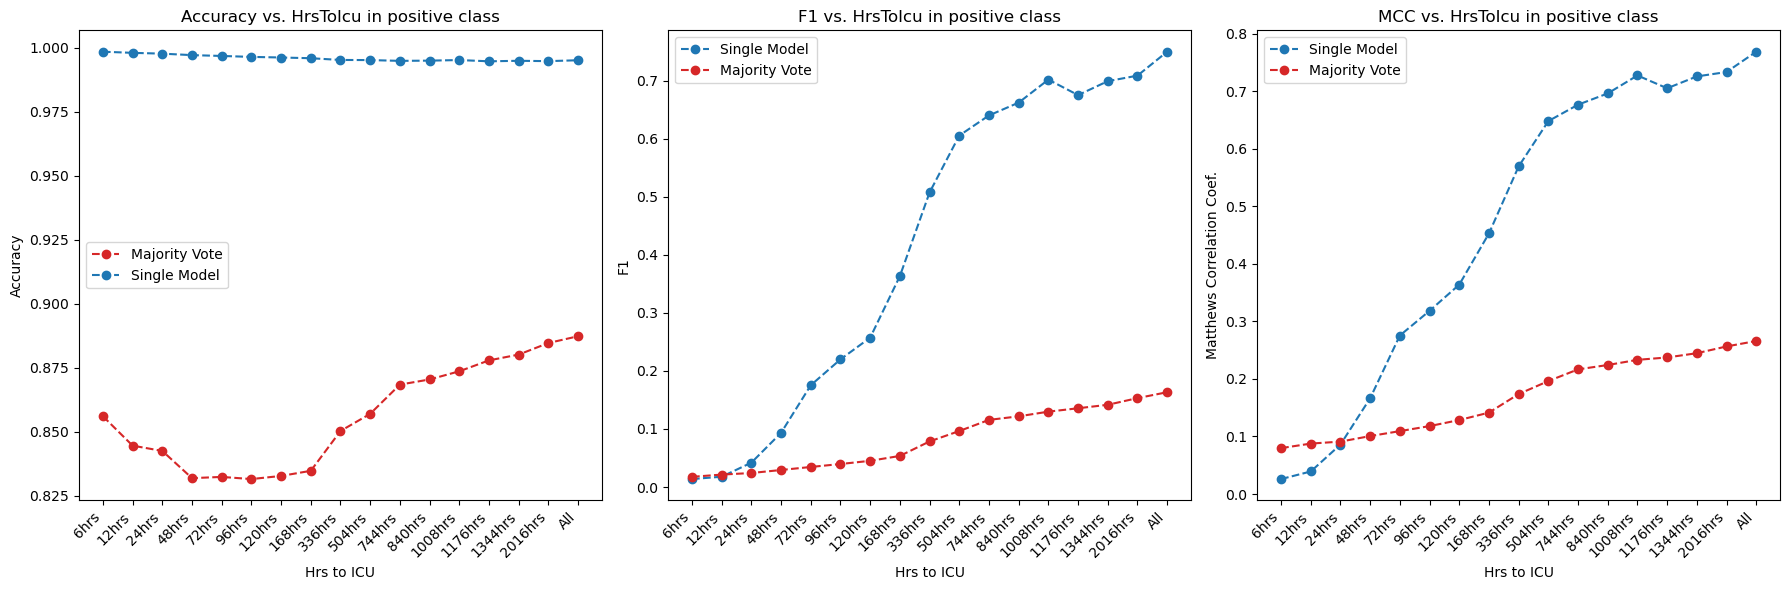

In [120]:
# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Accuracy scores
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(num_hours,accuracy_scores_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote')
plt.plot(num_hours,accuracy_scores_single_model, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Single Model')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. HrsToIcu in positive class')
plt.legend(loc = 'center left')


# Plot for F1 Scores
plt.subplot(1, 3, 2)
plt.plot(num_hours,f1_scores_single_model, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Single Model')
plt.plot(num_hours,f1_scores_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('F1')
plt.title('F1 vs. HrsToIcu in positive class')
plt.legend()


# Plot for MCC Scores
plt.subplot(1, 3, 3)
plt.plot(num_hours,mcc_scores_single_model, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Single Model')
plt.plot(num_hours,mcc_scores_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Matthews Correlation Coef.')
plt.title('MCC vs. HrsToIcu in positive class')

plt.legend()
plt.tight_layout()
plt.show()

The single model seems to outperform the majority vote approach by a large margin across all the 
HrsToIcu subsets. It does best with all the data, as seen in other visualizations earlier in the notebook. 

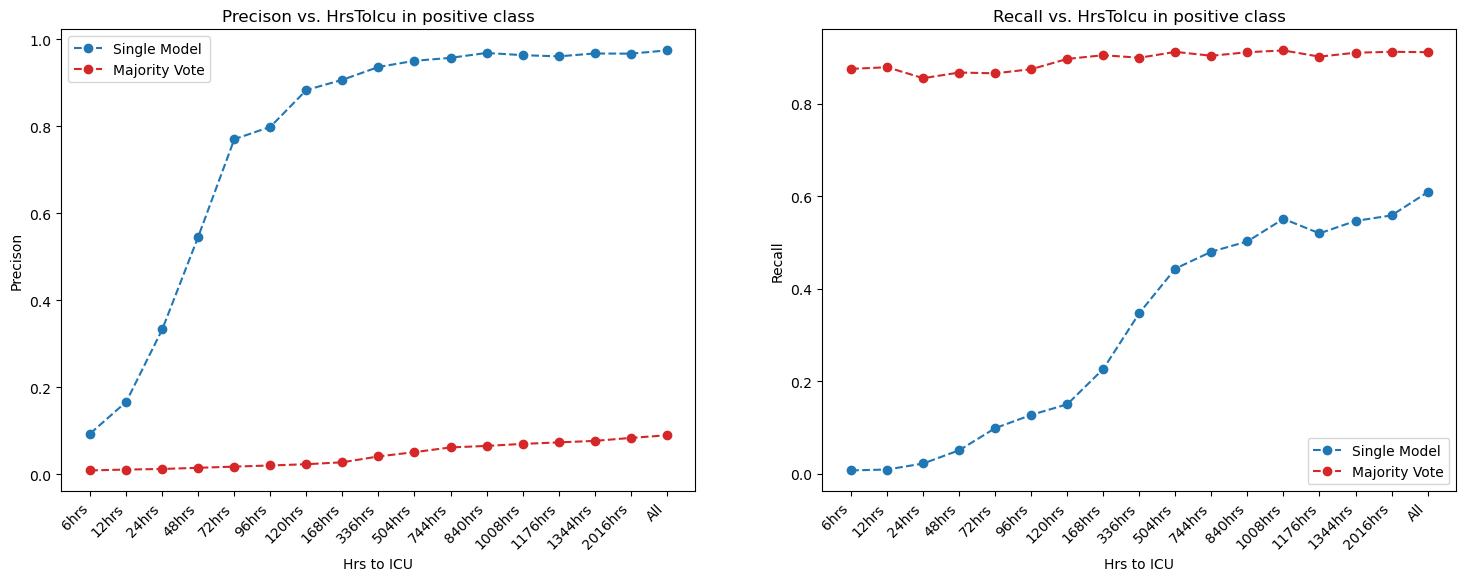

In [122]:
#Visualize Precison and Recall

# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Precision scores
plt.subplot(1, 2, 1)  # (rows, cols, subplot_index)
plt.plot(num_hours,precison_single_model, marker = 'o',color='tab:blue' ,linestyle = '--',label = 'Single Model')
plt.plot(num_hours,precison_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Precison')
plt.title('Precison vs. HrsToIcu in positive class')
plt.legend()


# Plot for Recall Scores
plt.subplot(1, 2, 2)
plt.plot(num_hours,recall_single_model, marker = 'o',color='tab:blue' ,linestyle = '--',label = 'Single Model')
plt.plot(num_hours,recall_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--',label = 'Majority Vote')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Recall')
plt.title('Recall vs. HrsToIcu in positive class')
plt.legend()

plt.show()


The single model has much higher precison across all subsets and much lower recall. As noted above, the majority vote approach seems to maximize recall
at the expense of other metrics. 

## <a id='toc14_1_'></a>[Run models with engineered features removed](#toc0_)

In [105]:
#Try same appraoch but remove all the features, just keep the blood tests. - Run a single model and majoroty vote protocol

hrsToIcu_df_dict_scores_single_model_no_features = {}
hrsToIcu_df_dict_scores_majority_vote_no_features = {}

for key in hrsToIcu_df_dict.keys():

    #count and print the iteration
    print(key)

    df = hrsToIcu_df_dict[key]
    
    #drop columns and encode
    cols_to_drop = ['Id','Diagnosis','Center','SecToIcu','CRP','PCT','HrsToIcu', 'test_sequence', 'interval_from_last_test', 'mean_time_between_tests',
       'median_time_between_tests', 'HGB_cumulative_mean',
       'HGB_cumulative_median', 'HGB_cumulative_std', 'HGB_ema_span_6',
       'HGB_ema_span_2', 'MCV_cumulative_mean', 'MCV_cumulative_median',
       'MCV_cumulative_std', 'MCV_ema_span_6', 'MCV_ema_span_2',
       'PLT_cumulative_mean', 'PLT_cumulative_median', 'PLT_cumulative_std',
       'PLT_ema_span_6', 'PLT_ema_span_2', 'RBC_cumulative_mean',
       'RBC_cumulative_median', 'RBC_cumulative_std', 'RBC_ema_span_6',
       'RBC_ema_span_2', 'WBC_cumulative_mean', 'WBC_cumulative_median',
       'WBC_cumulative_std', 'WBC_ema_span_6', 'WBC_ema_span_2']
    
    df_dropped = df.drop(columns=cols_to_drop)

    df_encoded = pd.get_dummies(df_dropped, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)

    #train test split
    X_df = df_encoded.drop(columns = ['Class'])
    y_df  = df_encoded['Class']

    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

 
 
   # Single XGBoost model
    model = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores_single_model = create_classifier_scores_object(y_test, y_pred, print_results=False)

    #save scores object
    scores_key = key + '_scores'
    hrsToIcu_df_dict_scores_single_model_no_features[scores_key] = scores_single_model


   #Majority Vote Model
   #Generate voting matrix and scores object
    matrix = XGB_majority_vote(X_train, y_train, X_test, iter = 100,threshold = 0.5, sampling_strategy = 'auto', return_matrix=True)
    scores_majority_vote = create_classifier_scores_object(y_test, matrix['Majority_vote'], print_results=False)

    #save scores object
    scores_key = key + '_scores'
    hrsToIcu_df_dict_scores_majority_vote_no_features[scores_key] = scores_majority_vote

6hrs_to_ICU
12hrs_to_ICU
24hrs_to_ICU
48hrs_to_ICU
72hrs_to_ICU
96hrs_to_ICU
120hrs_to_ICU
168hrs_to_ICU
336hrs_to_ICU
504hrs_to_ICU
744hrs_to_ICU
840hrs_to_ICU
1008hrs_to_ICU
1176hrs_to_ICU
1344hrs_to_ICU
2016hrs_to_ICU
All_hrs_to_ICU


In [107]:
#Generate data for vizualizations
num_hours = []

accuracy_scores_no_features_single_model = []
f1_scores_no_features_single_model= []
mcc_scores_no_features_single_model = []
precison_no_features_single_model = []
recall_no_features_single_model = []

accuracy_scores_no_features_majority_vote = []
f1_scores_no_features_majority_vote= []
mcc_scores_no_features_majority_vote = []
precison_no_features_majority_vote = []
recall_no_features_majority_vote = []


for key in  hrsToIcu_df_dict_scores_single_model_no_features.keys():
    num_hours.append(key)
    accuracy_scores_no_features_single_model.append(hrsToIcu_df_dict_scores_single_model_no_features[key].accuracy)
    f1_scores_no_features_single_model.append(hrsToIcu_df_dict_scores_single_model_no_features[key].f1)
    mcc_scores_no_features_single_model.append(hrsToIcu_df_dict_scores_single_model_no_features[key].mcc)
    precison_no_features_single_model.append(hrsToIcu_df_dict_scores_single_model_no_features[key].precision)
    recall_no_features_single_model.append(hrsToIcu_df_dict_scores_single_model_no_features[key].recall)

for key in  hrsToIcu_df_dict_scores_majority_vote_no_features.keys():
    accuracy_scores_no_features_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote_no_features[key].accuracy)
    f1_scores_no_features_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote_no_features[key].f1)
    mcc_scores_no_features_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote_no_features[key].mcc)
    precison_no_features_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote_no_features[key].precision)
    recall_no_features_majority_vote.append(hrsToIcu_df_dict_scores_majority_vote_no_features[key].recall)


for i in range(len(num_hours)):
    num_hours[i] = num_hours[i].split('_', 1)[0]


## <a id='toc14_2_'></a>[Visualize Features vs. No Features and Single vs. Majority Vote together](#toc0_)

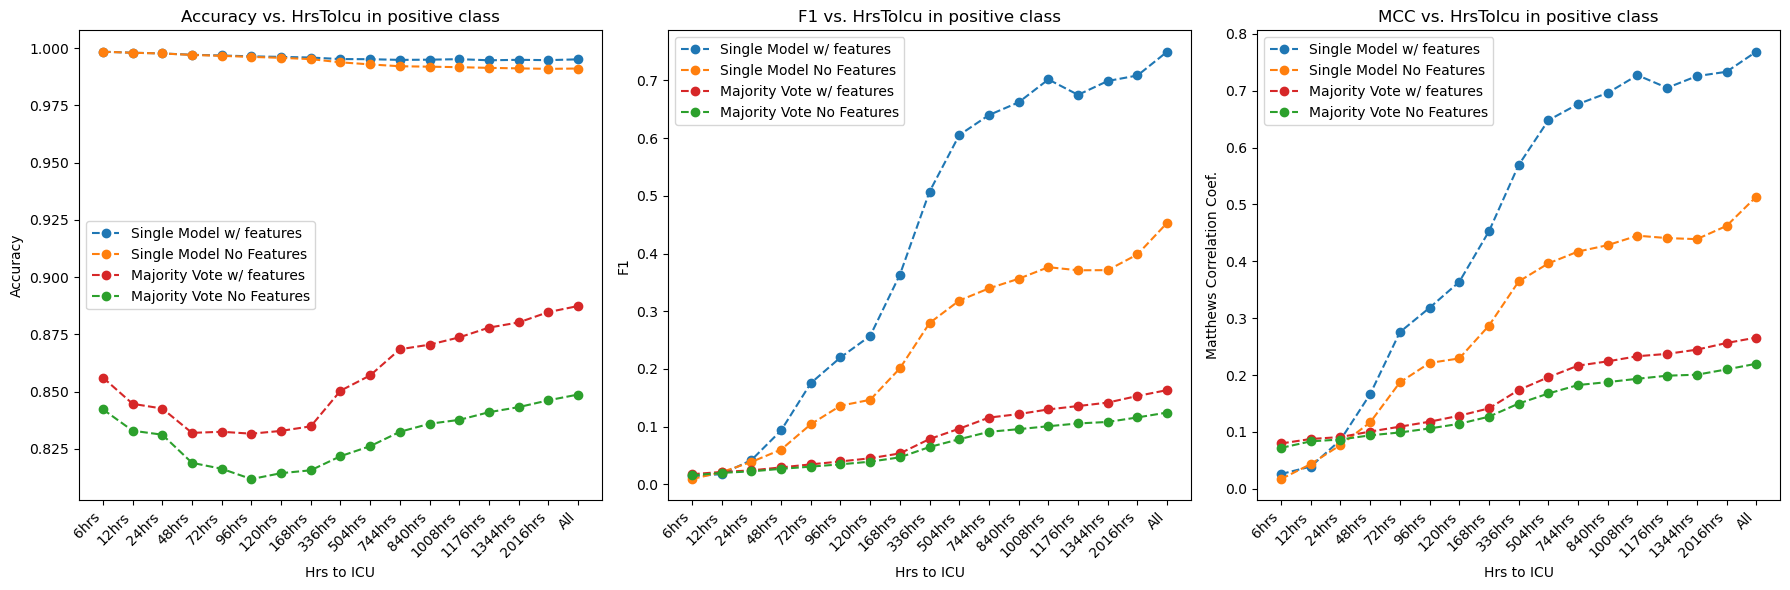

In [111]:
# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Accuracy scores
plt.subplot(1, 3, 1)  # (rows, cols, subplot_index)
plt.plot(num_hours,accuracy_scores_single_model, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Single Model w/ features')
plt.plot(num_hours,accuracy_scores_no_features_single_model, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'Single Model No Features')
plt.plot(num_hours,accuracy_scores_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote w/ features ')
plt.plot(num_hours,accuracy_scores_no_features_majority_vote, marker = 'o',color='tab:green' ,linestyle = '--', label = 'Majority Vote No Features')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. HrsToIcu in positive class')
plt.legend()


# Plot for F1 Scores
plt.subplot(1, 3, 2)
plt.plot(num_hours,f1_scores_single_model, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Single Model w/ features')
plt.plot(num_hours,f1_scores_no_features_single_model, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'Single Model No Features')
plt.plot(num_hours,f1_scores_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote w/ features')
plt.plot(num_hours,f1_scores_no_features_majority_vote, marker = 'o',color='tab:green' ,linestyle = '--', label = 'Majority Vote No Features')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('F1')
plt.title('F1 vs. HrsToIcu in positive class')
plt.legend()


# Plot for MCC Scores
plt.subplot(1, 3, 3)
plt.plot(num_hours,mcc_scores_single_model, marker = 'o',color='tab:blue' ,linestyle = '--', label = 'Single Model w/ features')
plt.plot(num_hours,mcc_scores_no_features_single_model, marker = 'o',color='tab:orange' ,linestyle = '--', label = 'Single Model No Features')
plt.plot(num_hours,mcc_scores_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote w/ features')
plt.plot(num_hours,mcc_scores_no_features_majority_vote, marker = 'o',color='tab:green' ,linestyle = '--', label = 'Majority Vote No Features')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Matthews Correlation Coef.')
plt.title('MCC vs. HrsToIcu in positive class')

plt.legend()
plt.tight_layout()
plt.show()

Removing the engineered features degrades performance in both the single model and the majority vote protocol. 
The engineered features certainly seem to be adding somthing. Their exact contributions should become clearer
during the modeling phase. 

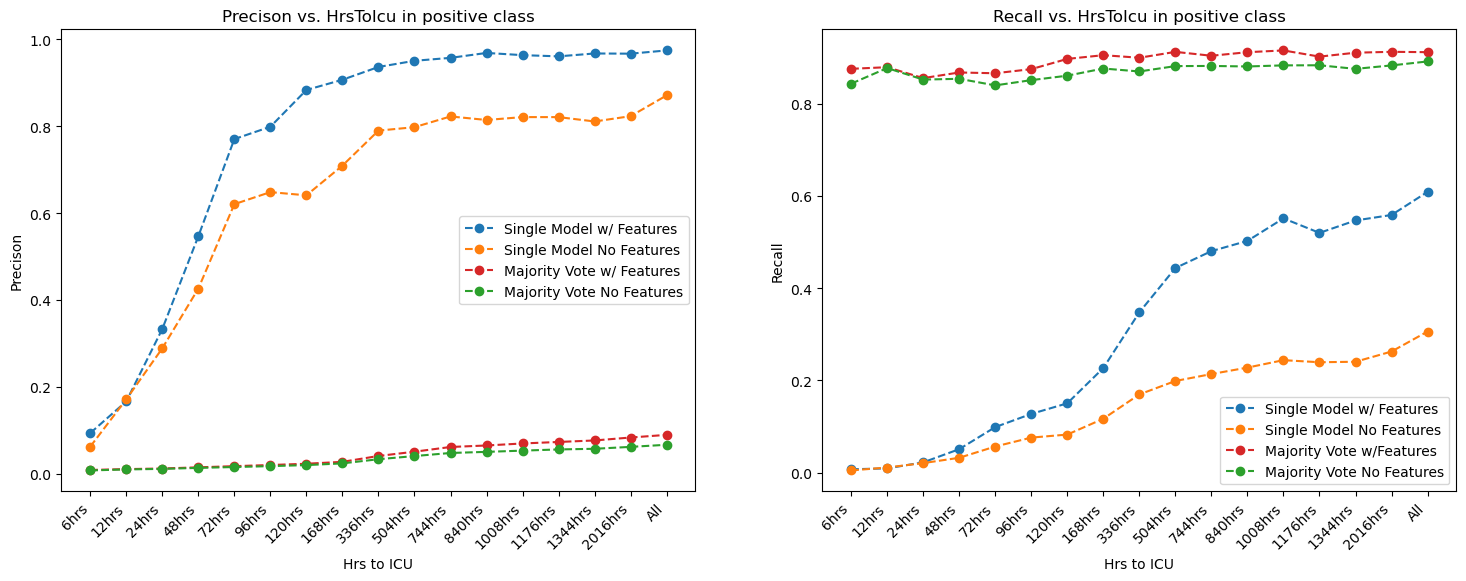

In [115]:
#Visualize Precison and Recall

# Create a figure and set of subplots
plt.figure(figsize=(18, 6))

# Plot for Precision scores
plt.subplot(1, 2, 1)  # (rows, cols, subplot_index)
plt.plot(num_hours,precison_single_model, marker = 'o',color='tab:blue' ,linestyle = '--',label = 'Single Model w/ Features')
plt.plot(num_hours,precison_no_features_single_model, marker = 'o',color='tab:orange' ,linestyle = '--',label = 'Single Model No Features')
plt.plot(num_hours,precison_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--', label = 'Majority Vote w/ Features')
plt.plot(num_hours, precison_no_features_majority_vote, marker = 'o',color='tab:green' ,linestyle = '--',label = 'Majority Vote No Features')

plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Precison')
plt.title('Precison vs. HrsToIcu in positive class')
plt.legend()


# Plot for Recall Scores
plt.subplot(1, 2, 2)
plt.plot(num_hours,recall_single_model, marker = 'o',color='tab:blue' ,linestyle = '--',label = 'Single Model w/ Features')
plt.plot(num_hours, recall_no_features_single_model, marker = 'o',color='tab:orange' ,linestyle = '--',label ='Single Model No Features')
plt.plot(num_hours,recall_majority_vote, marker = 'o',color='tab:red' ,linestyle = '--',label = 'Majority Vote w/Features')
plt.plot(num_hours,recall_no_features_majority_vote, marker = 'o',color='tab:green' ,linestyle = '--',label ='Majority Vote No Features')
plt.xticks(num_hours, rotation=45, ha='right')
plt.xlabel('Hrs to ICU')
plt.ylabel('Recall')
plt.title('Recall vs. HrsToIcu in positive class')
plt.legend()

plt.show()

By now the pattern here is becoming familiar. The features are adding performance in a gneral sense and the best approach seems to be a single model with all the features and
all the data. 

# <a id='toc15_'></a>[Summary](#toc0_)

In this notebook I used data from the Leipzig medical center to explore different modeling approaches. Leipzeig is the larger of the two centers I have data for and I used it exclusively only because it’s the biggest center. Keeping with the idea of treating the centers separately it’s really the only choice. Using only one center also simplifies everything substantially in terms of preprocessing. The Griefswald center will be brought into the process in following notebook(s) during the modeling phase. The various approaches tried are detailed below. 

## <a id='toc15_1_'></a>[Approach 1 - Single XGBoost model](#toc0_)

This was a basic XGBoost model using all data with all engineered features. Class in this case is defined by a Sepsis diagnosis. This meant that some of the blood samples are taken weeks round months before the patient was actually admitted to the ICU. Even so, initial results from this data were promising based on the precision recall curve and confusion matrix

## <a id='toc15_2_'></a>[Approach 2 - Sliding time window for positive and negative clasess](#toc0_)

The features are all the same but a sliding window was applied. So the data set here consists of all data within 6 hour increments. When the sliding window was applied, most of the data clustered in the first window of 0-6 hours. This seems to be because most of the data has a time value of 0, indicating that the patient was tested only once. Based on the methodology applied, all of the rows with a  0 time value would default to the 0-6 hour window. This clustering in the first window made looking at the other sliding time windows irrelevant, because they were so much smaller. The preliminary modeling results on the 0-6 hour window were also poor. The sliding time window approach was not pursued further. See the notebook ’01_rb_feature_engineering’ for more detail on this approach 

## <a id='toc15_3_'></a>[Approach 3 - Majority Vote with XGBoost](#toc0_)

This approach also used an XGBoost model, and all of the engineered features. It involved running the model on the data for multiple iterations and then taking a majority vote from all of those iterations to determine the final prediction. So given 100 iterations if the model predicted a point in the test set was in the negative class 51 times, the final prediction for that point would be the negative class. This approach was run for the same data set as approach 1 across multiple iteration values and multiple threshold classification values to get a general feel for how the data and model would interact. 

The use of majority voting was meant to help separate signal from noise via multiple iterations. It was not terribly successful in that it did not yield improvements in performance. Performance actually became worse in many cases as the number of iterations increased. The overall effect of the majority of the majority voting seemed to be increase recall by a large margin, while greatly other metrics. High recall is desirable in terms of disease detection, so this effect may bear a second look in the modeling phase if it can be applied differently, perhaps with fewer iterations. The minimum tried here was 100. Trying something like 10 iterations might be interesting during the modeling phase. That being said, based on the results here, this approach does not seem worth a lot of additional effort. 


## <a id='toc15_4_'></a>[Approach 4 - Subsetting Positive Class on time from ICU admission](#toc0_)

This approach used all the same features from the others, but subset the positive class to include only blood tests that were taken within some time window prior to ICU admission. 
The negative class was unchanged. See the feature engineering notebook for more detail on how the data was subset along these lines. 

Using the data subset on a 6 hour window (similar to what the publishers of the paper used). I ran a first pass with an XGBoost model without majority voting or under-sampling. The results were predictably bad, since the existing class imbalance had been made considerably worse when the size of the positive class was reduced to the samples from the 6 hour window.

I then tried the same XGBoost model with undersampling, and compared the results across multiple threshold values. The results were again not good. The model in this case was being trained on about 1,600 examples of the positive class and negative class at a 1-1 ration. It was being tested on about 400 examples of each. This seems like just not enough data for a robust result. 

I tried the same approach but with the majority vote function. The model, size of the training and test sets, and the under-sampling protocol stayed the same, but the model was run between 100 and 2000 times and a majority vote from the model results was used for prediction. This also resulted in poor performance, but this time with many more false positives than previous efforts. 

## <a id='toc15_5_'></a>[Final comparisons and next steps](#toc0_)

Finally, I generated a set of visualizations comparing general performance of both the single model and majority voting approach. This was done with and without the engineered features. All previous efforts here had run on the assumption that the features were adding to performance, which I wanted to test. The results of this comparison can be summer up as follows:

- A single model performs better than using the majority vote function

- Using all the data is better than subsetting the positive class based on proximity to ICU admission.

- Using the engineered features is better than not using them. 


This suggests two tracks for further efforts in the modeling phase. Both tracks will use a single model approach and all of the engineered features. Both tracks may also make use of oversampling of the positive class. Something that was not tried in this notebook, but which may be useful moving forward. 


### <a id='toc15_5_1_'></a>[Full data Track](#toc0_)

The best results here are based on using the full data set. This track will keep the full data set and try to improve performance through trying additional models,  hyper-parameter tuning, and different sampling regimes. 

### <a id='toc15_5_2_'></a>[Time from ICU track](#toc0_)

The publishers of the original paper made a point of treating the positive class as only patients  with a blood test within 6 hours of ICU admission. The results from using this approach in the notebook above were not promising at all, and I don’t have access to what I presume is the sound medical reasoning behind this approach. Even so, the published results using a 6 hour window were also pretty good, and I want to explore it further. It’s possible that a different model, or some regime of under sampling and over sampling will yield better results. 